# Predictive Modelling of Proteomics using a Transformer Model

## Task Type and Model Decision
This task is a regression task, where one type of omics data is predicted using others. Both VAEs and Transformers are suitable choices: VAEs excel with noisy data and handle missing values well, while Transformers are powerful for capturing complex interactions between features through their self-attention mechanism.

I selected a Transformer model because the multi-head attention can learn different types of relationships between omics data features and capturing various correlations that might exist. The self-attention mechanism allows the model to identify important feature interactions, which I think are important in multi-omics data integration. While VAEs would also be suitable, particularly for handling noise and missing values, the potential complex interactions between omics data features made Transformers my preferred choice.

## Data
The aim is to use multiple input omics datasets to predict proteomics data. Input omics data was selected by iteratively testing combinations to determine which best predicted proteomics. This indicated that transcriptomics data only as the optimal input combination for proteomics prediction.

## Plan
The approach follows a systematic comparison between a baseline MLP model and the Transformer architecture:

1. [Inspect data](#inspect-data);
2. [Create a simple MLP model](#baseline-mlp) as a baseline;
3. [Develop Transformer models](#transformer-models) with different fusion strategies and activation functions;
4. [Perform hyperparameter tuning](#hyperparameter-tuning);
5. [Conduct progressive input omics selection](#omics-selection);
6. [Create comprehensive loop](#evaluation-loop) to iterate through steps 3-5, obtaining metrics to determine the best Transformer model for comparison with the baseline MLP;
7. [Analyse best-predicted proteomic features](#feature-analysis);

## Results
- The [baseline MLP model](#results-MLP) performed quite well already, with an R^2 ~0.83, an RMSE ~0.69, and prediction errors that are roughly Normally distributed.
- The best [Transformer model](#results-transformer) demonstrated that using transcriptomics data only as input omics data performed best, with R^2 ~0.83. However, rerunning the algorithm shows some variability in the best performing hyperparameters, such as fusion method selected. In addition, the Transformer model does not significantly outperform the baseline MLP model. Moving forward, cross-validation and improved data handling (e.g. outlier handling) would be worth exploring. 
- The results of the [feature analysis](#results-feature-analysis) showed significant correlation values >0.5 between the predicted and actual values. However, the R^2 values are low, indicating that while the general trends in protein expression are captured, the model does not accurately predict the exact values. 

## Future Work
Given more time, I would implement:

1. Cross-validation for more robust model evaluation;
2. Enhanced data handling, particularly for outliers. Despite the task stating the data was "processed and cleaned, so you can use them directly" I encountered outliers that might affect results. Going forward, I would address these outliers prior to modelling;
3. Development of ensemble methods to potentially improve prediction accuracy.



In [4]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import math
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

from scipy.stats import zscore, pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna

In [5]:
# CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Load data and create data paths
model_path = Path("models/")
result_path = Path("results/")
data_path_lung = Path("data/")  # lung carcinome data

# Check if the directories exist, and create them if they don't
if not model_path.exists():
    model_path.mkdir(parents=True)
if not result_path.exists():
    result_path.mkdir(parents=True)
if not data_path_lung.exists():
    data_path_lung.mkdir(parents=True)

# Load data
prefix = "20231023_092657_"
datasets = {
    "methylation": pd.read_csv(data_path_lung / f"{prefix}imputed_methylation.csv"),
    "metabolomics": pd.read_csv(data_path_lung / f"{prefix}imputed_metabolomics.csv"),
    "proteomics": pd.read_csv(data_path_lung / f"{prefix}imputed_proteomics.csv"),
    "transcriptomics": pd.read_csv(data_path_lung / f"{prefix}imputed_transcriptomics.csv"),
    "cnv": pd.read_csv(data_path_lung / f"{prefix}imputed_copynumber.csv"),
}

# Inspect Data <a id="inspect-data"></a>

This part includes:
- Loading the data;
- Quick scan through data to get an intuition;
- Visualise the distribution and characteristics of the data:
    - Distribution plots: skewness, normality, etc.
    - Boxplots: median, quartiles, and outliers for first 20 features.
    - Heatmap: patterns, clusters, and correlations between samples and features.
    - Z-score: outlier detection.
    - PCA: the PC that explains most of the variance.

In [7]:
# Get the patient ID column name
patient_id_col = list(datasets.values())[0].columns[0]

# Reference/Target dataset, i.e. proteomics
reference = "proteomics"
reference_df = datasets[reference]
reference_ids = list(reference_df[patient_id_col])

# Check all datasets
for name, df in datasets.items():
    current_ids = list(df[patient_id_col])

    # Check if patient IDs are the same
    same_ids = set(reference_ids) == set(current_ids)
    print(f"{name}: Same IDs as {reference}: {same_ids}")

    # Check if patient IDs are in the same order
    same_order = reference_ids == current_ids
    print(f"{name}: Same order as {reference}: {same_order}")
    print(f"-------------------------------------------------\n")

methylation: Same IDs as proteomics: True
methylation: Same order as proteomics: True
-------------------------------------------------

metabolomics: Same IDs as proteomics: True
metabolomics: Same order as proteomics: True
-------------------------------------------------

proteomics: Same IDs as proteomics: True
proteomics: Same order as proteomics: True
-------------------------------------------------

transcriptomics: Same IDs as proteomics: True
transcriptomics: Same order as proteomics: True
-------------------------------------------------

cnv: Same IDs as proteomics: True
cnv: Same order as proteomics: True
-------------------------------------------------



In [8]:
print(datasets["proteomics"].shape)
datasets["proteomics"].head()

(175, 4923)


,Unnamed: 0,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
0,SIDM00046,3.35516,2.47970,2.64814,3.42747,2.29730,2.79989,5.03959,4.36283,2.83884,...,0.94939,1.96832,4.87203,3.54926,2.74466,3.96470,2.31081,1.44500,2.23063,4.87281
1,SIDM00047,3.47470,1.78254,3.52149,2.92188,1.37197,2.97951,5.14901,3.88597,3.55916,...,0.84154,1.78003,3.42515,2.79853,3.20215,4.02278,2.24471,1.87061,1.76904,4.96541
2,SIDM00048,3.56201,2.52743,3.26977,3.48947,2.15151,2.75366,5.11889,3.51744,3.29552,...,1.34557,2.03291,4.14519,3.22756,3.29044,3.98339,2.58220,2.09735,2.47003,4.91925
3,SIDM00098,3.50973,2.33440,3.43963,3.32111,2.48636,3.17103,5.59721,3.94357,3.56998,...,0.81172,1.79803,4.24853,3.12697,3.93978,4.55265,2.63257,1.90050,2.06059,5.91146
4,SIDM00099,3.54051,2.12653,2.91819,2.84000,2.05342,2.33734,4.71901,3.52292,2.09409,...,0.35651,1.80656,3.25177,2.95097,2.55263,3.52448,2.67204,1.77170,1.80426,5.53598


In [9]:
print(datasets["transcriptomics"].shape)
datasets["transcriptomics"].head()

(175, 15279)


,Unnamed: 0,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,SIDM00046,2.04090,-5.30627,-1.25004,-1.32172,3.00924,5.27339,5.77792,-1.93157,3.19395,...,5.30791,6.61797,1.60898,3.89132,5.07034,1.43384,4.89578,7.85737,6.32957,5.04573
1,SIDM00047,1.01151,-3.45882,-0.39178,-3.98753,3.27545,5.79755,5.27295,0.06323,3.18109,...,5.77799,6.63569,2.52953,4.19684,4.53901,-0.83239,5.21132,7.02936,5.91940,5.83587
2,SIDM00048,0.43384,-4.20756,-0.63528,-1.37044,3.80196,5.79006,5.56590,-1.02246,2.43433,...,5.56682,6.89185,2.52134,4.22761,4.88434,-0.38911,5.10613,7.08207,6.02523,5.65201
3,SIDM00098,1.69118,-4.16117,-0.22028,-4.65767,1.05576,5.66560,5.32404,-2.79352,1.49933,...,5.78098,6.65350,2.05654,3.92582,4.89359,-1.52334,5.17720,7.11551,6.26238,5.83334
4,SIDM00099,1.70960,-4.00844,0.29479,-5.20683,2.16290,5.71212,5.52738,-2.82416,1.96201,...,5.81931,6.61506,2.39253,4.15398,4.57227,-0.64660,5.43610,7.44160,6.32660,5.79604


In [10]:
# Check stats data
datasets["proteomics"].describe()

,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,AASDHPPT,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,...,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,3.400439,2.377934,3.177170,2.724059,2.341307,2.882409,5.523704,3.596709,3.037507,3.706307,...,0.650061,2.014989,4.119399,3.217272,3.493170,4.231324,2.505658,1.867428,2.051336,3.767167
std,0.470283,0.469785,0.417529,0.610718,0.729121,0.478877,0.851543,0.438702,0.812891,1.030560,...,0.453352,0.350896,0.721885,0.721797,0.930108,0.580388,0.350203,0.398492,0.359551,1.612974
min,2.261750,1.417240,1.937800,0.348690,0.660860,1.004400,2.631040,2.186440,-0.332310,0.492090,...,-0.676920,0.857180,1.500380,0.663890,-0.631570,1.852800,0.946650,0.617650,0.876150,-0.208100
25%,3.083055,2.025375,2.927475,2.354130,1.828220,2.615550,5.225035,3.301360,2.646140,2.995385,...,0.382670,1.822205,3.683940,2.722190,2.874340,3.895065,2.306375,1.650770,1.858410,2.222515
50%,3.398410,2.336890,3.234950,2.787770,2.334570,2.884420,5.616790,3.626200,3.122430,3.714160,...,0.688260,2.020420,4.148540,3.227560,3.600800,4.346080,2.550300,1.939080,2.060590,3.947790
75%,3.699850,2.747190,3.444095,3.162280,2.803920,3.199980,6.039545,3.868875,3.531480,4.502935,...,0.914440,2.244375,4.567050,3.721380,4.143840,4.680215,2.752860,2.114425,2.302500,5.132505
max,4.646800,3.519890,4.381370,3.862940,4.080070,3.987030,7.790930,4.779400,5.018770,6.268380,...,1.849370,3.149980,6.028390,4.803140,5.428910,5.374170,3.259980,2.710440,2.859270,6.776770


In [11]:
# Check missing values
for dataset_name, dataset in datasets.items():
    print(f"Checking missing data for {dataset_name} dataset...")
    
    if dataset.isnull().values.any():
        print(f"Missing data found in {dataset_name} dataset.")
        
        # Count missing values for each feature
        missing_counts = dataset.isnull().sum()
        ranked_features = missing_counts[missing_counts > 0].sort_values(ascending=False)
        print(f"Features with missing values (ranked):\n{ranked_features}\n")
    
    else:
        print(f"No missing data in {dataset_name} dataset.\n")

Checking missing data for methylation dataset...
No missing data in methylation dataset.

Checking missing data for metabolomics dataset...
No missing data in metabolomics dataset.

Checking missing data for proteomics dataset...
No missing data in proteomics dataset.

Checking missing data for transcriptomics dataset...
No missing data in transcriptomics dataset.

Checking missing data for cnv dataset...
No missing data in cnv dataset.



Analysing methylation dataset...


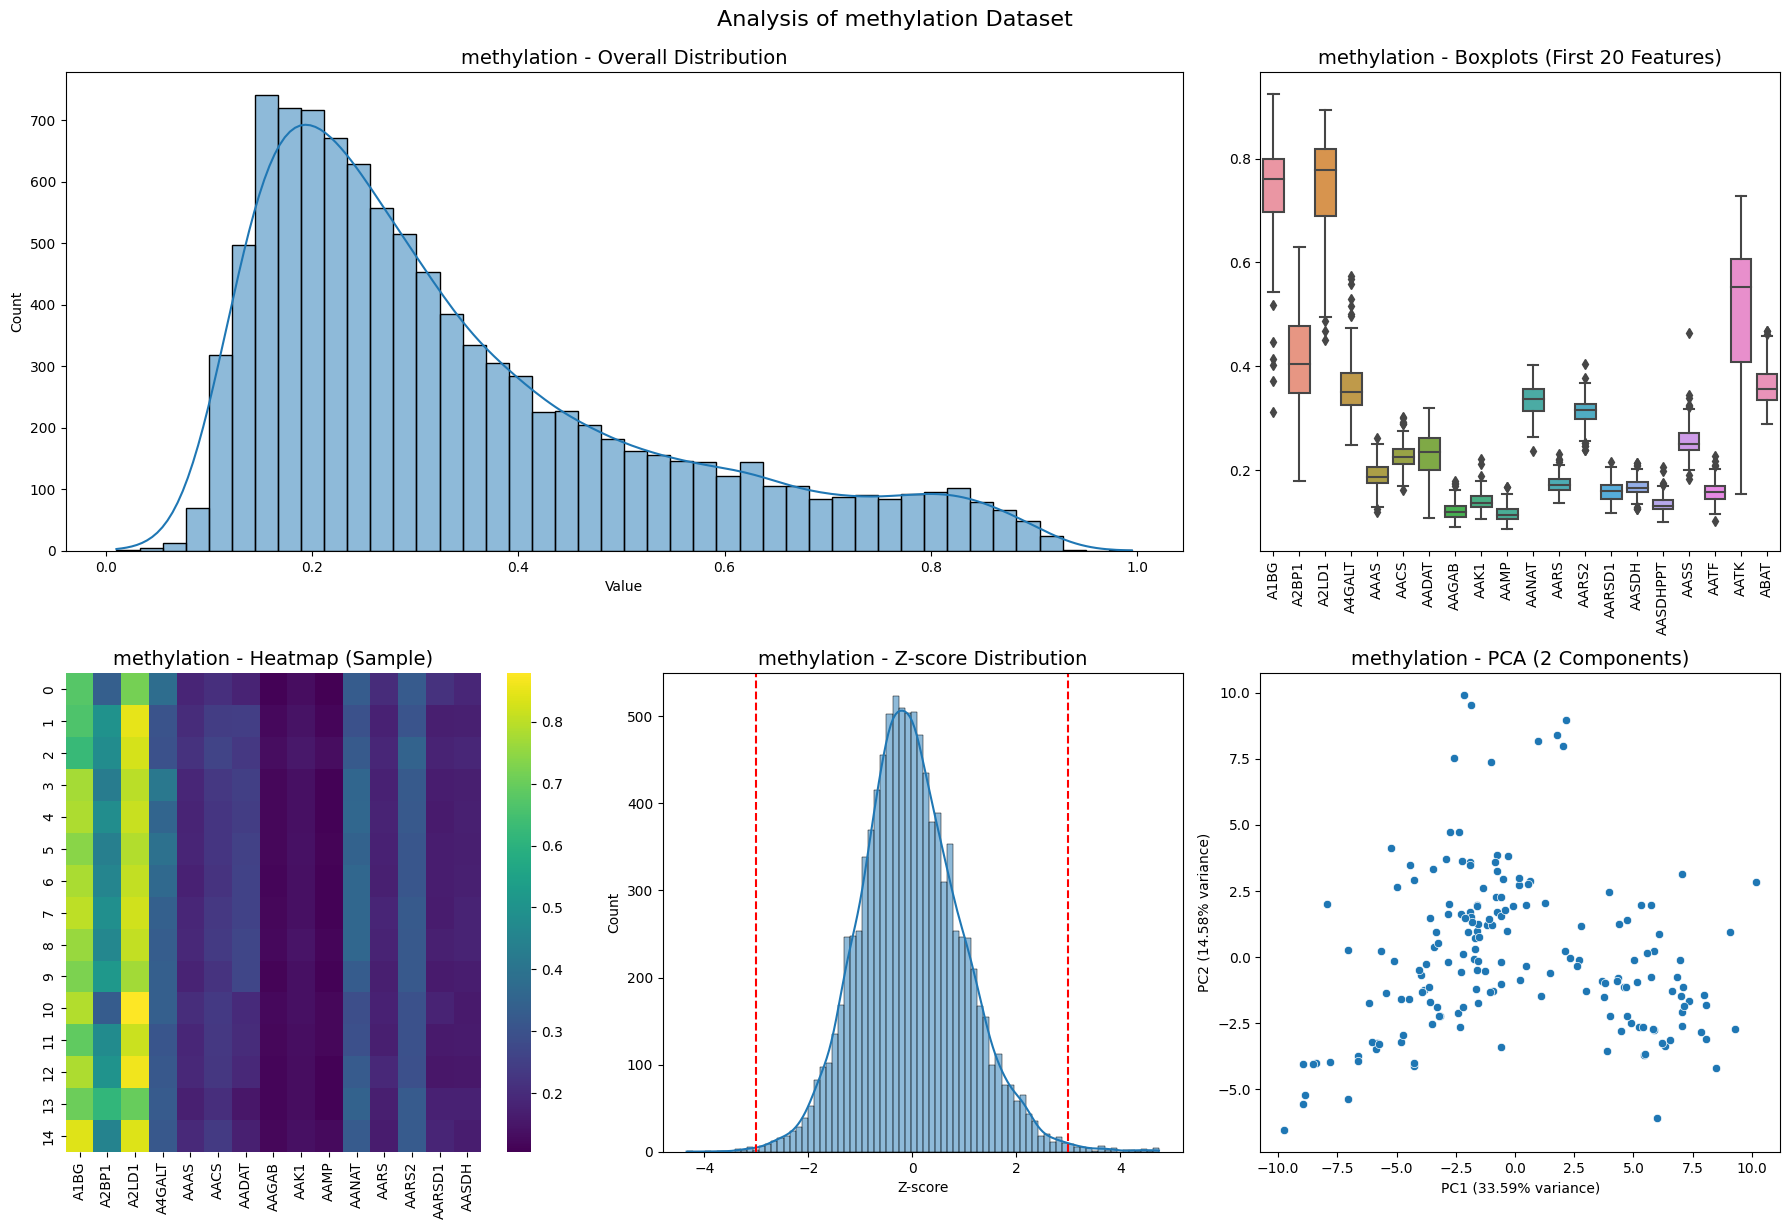

Analysing metabolomics dataset...


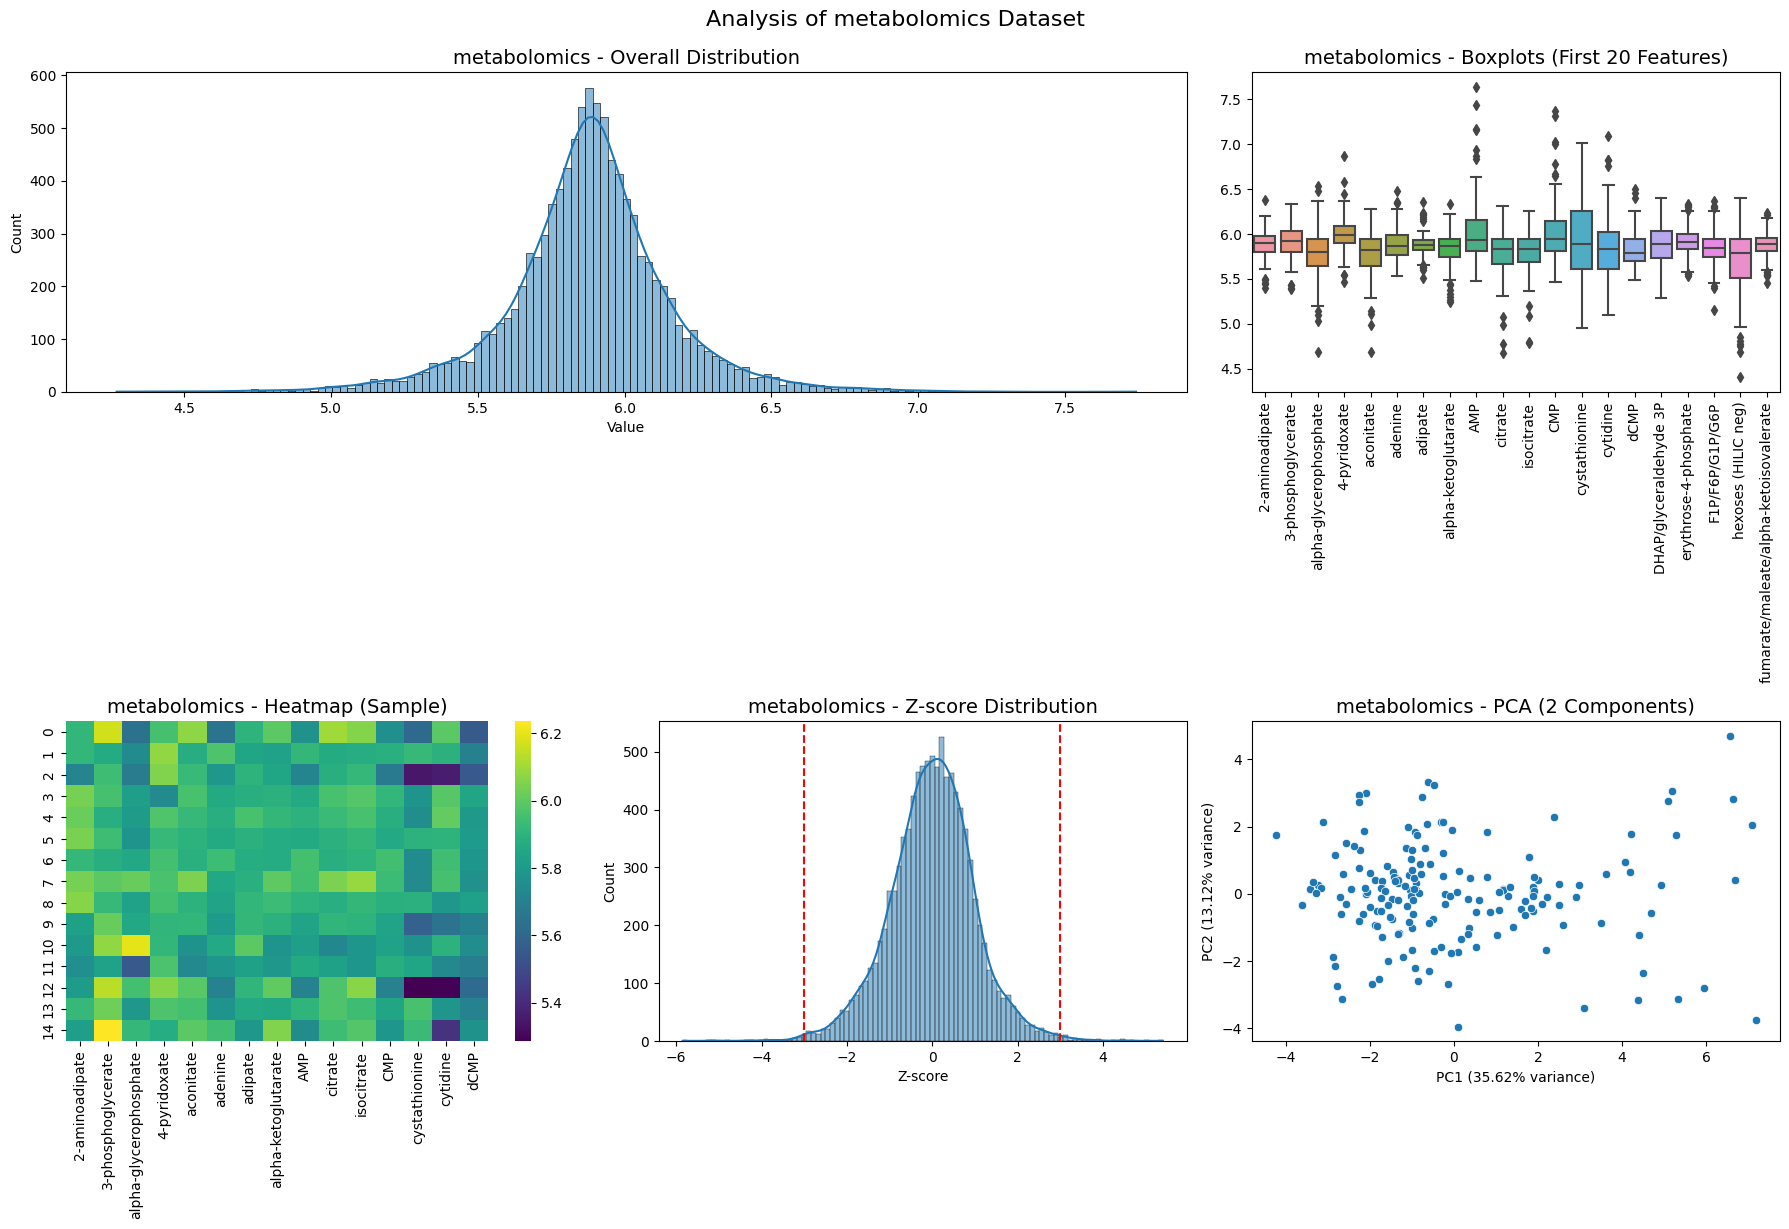

Analysing proteomics dataset...


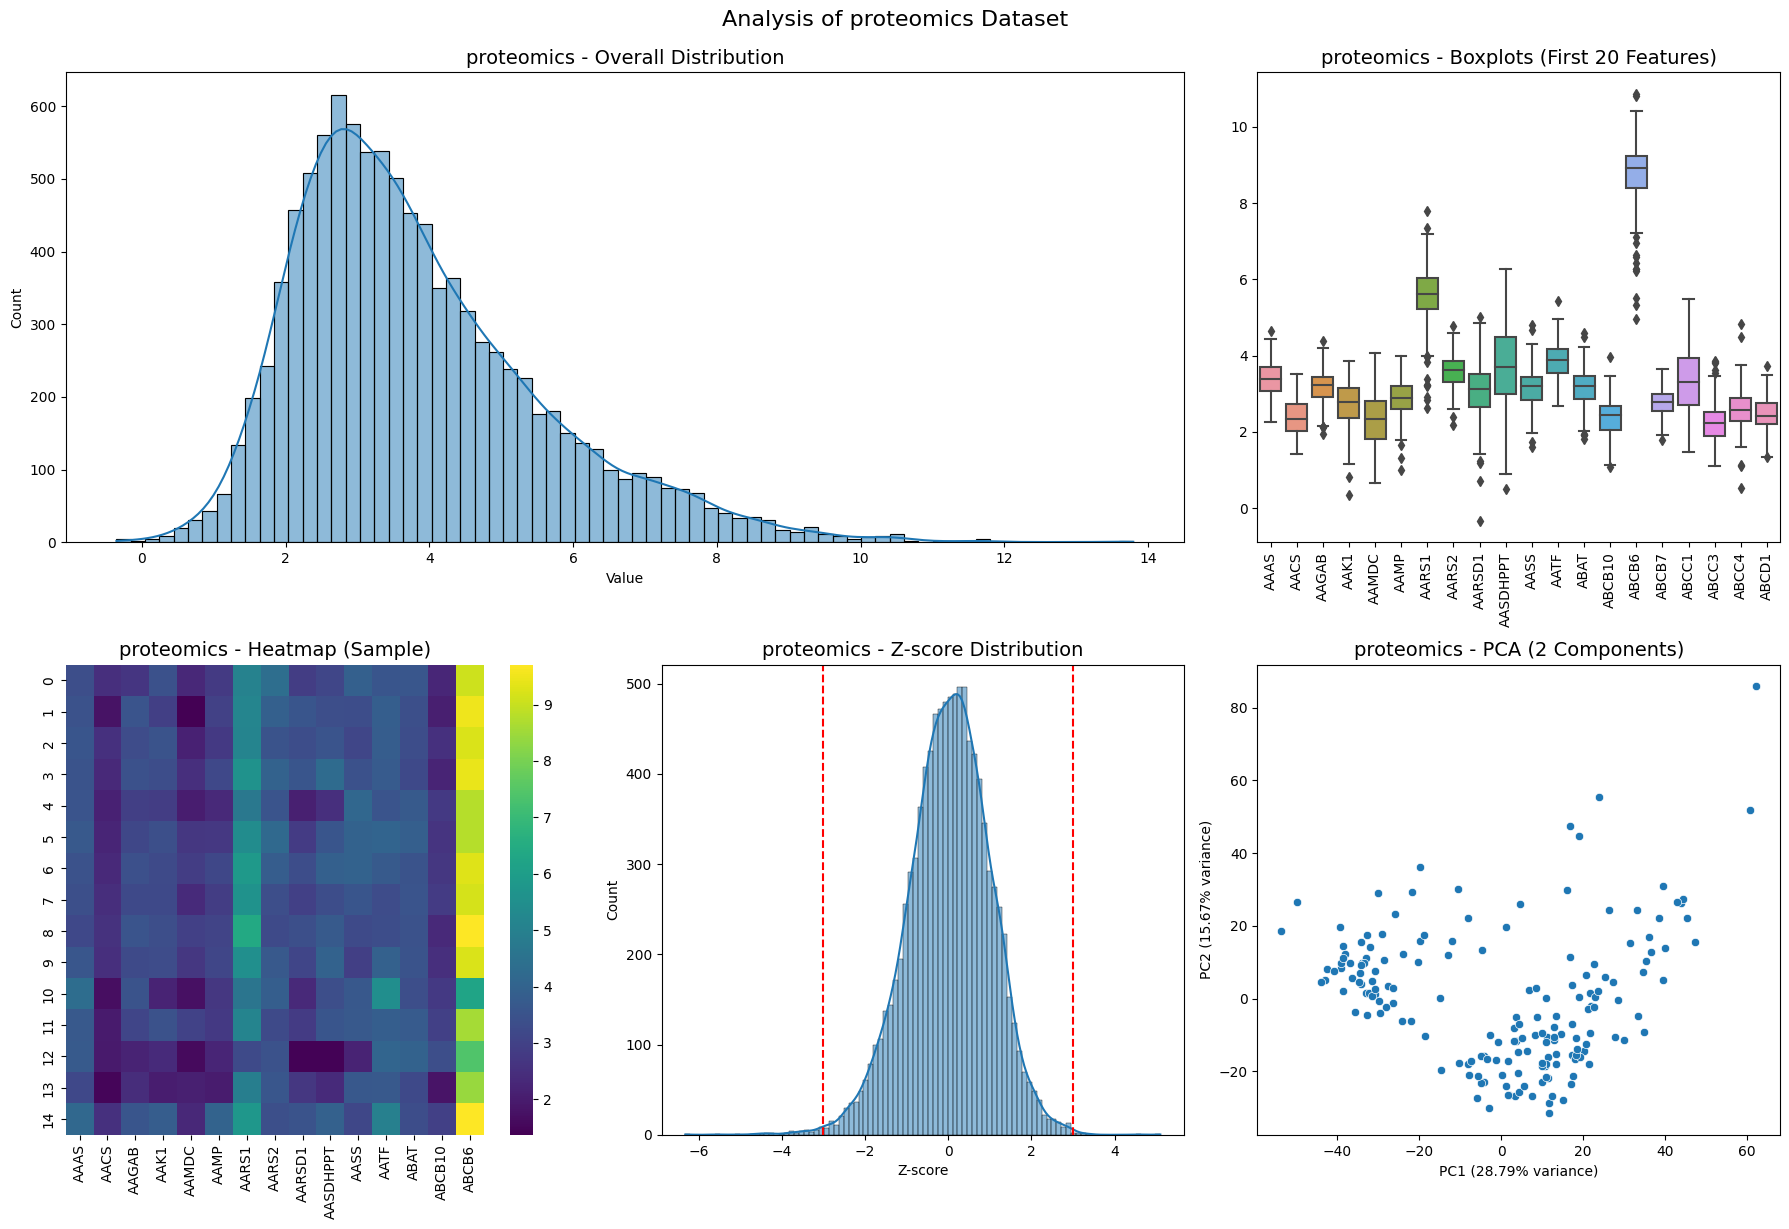

Analysing transcriptomics dataset...


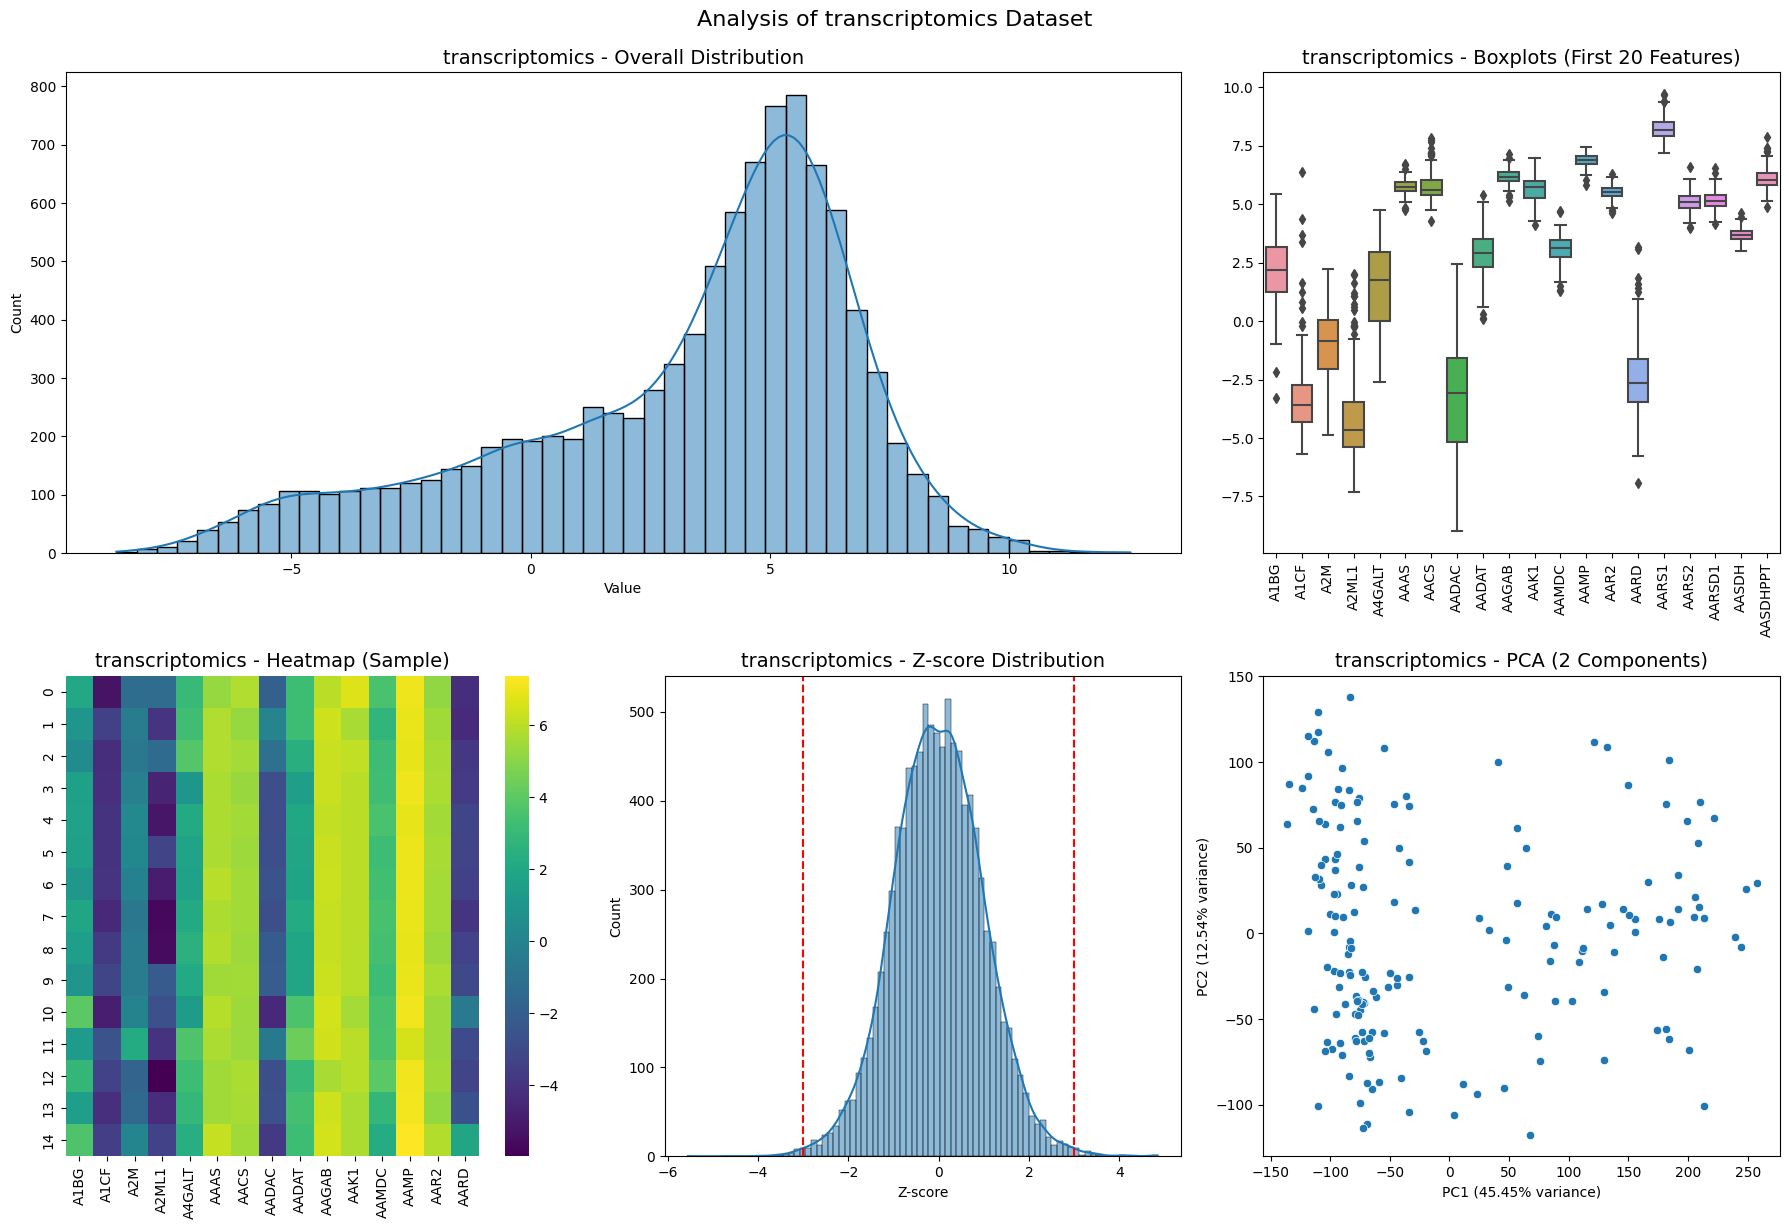

Analysing cnv dataset...


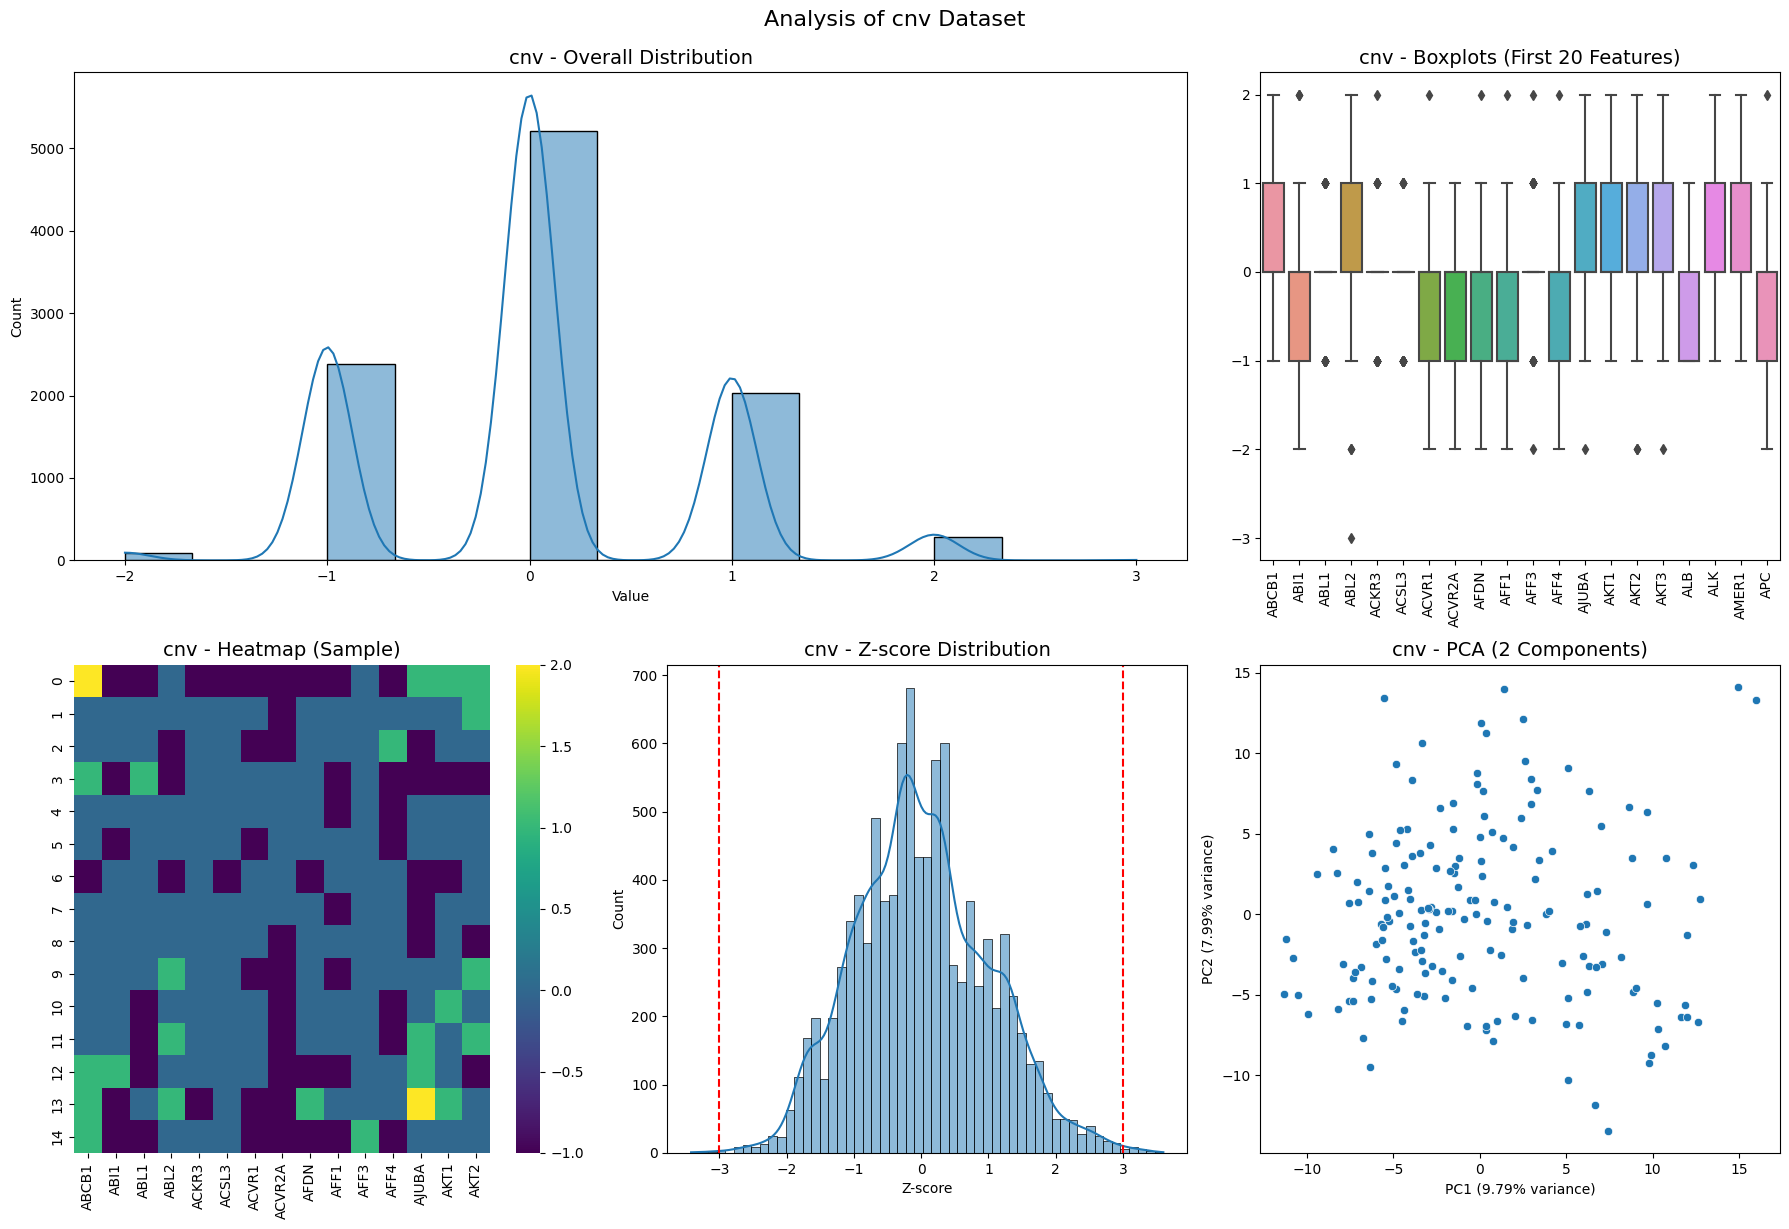

In [12]:
# Visualise data
def plot_distribution_and_outliers(dataset_name, dataset):
    """Visualise distribution and outliers for the datasets"""
    data = dataset.iloc[:, 1:]  # skip first column, as this is the sample ID
    
    # Plot
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
    
    # 1. Distribution plot
    ax1 = plt.subplot(gs[0, 0:2])
    sampled_values = data.values.flatten()
    np.random.shuffle(sampled_values)
    sampled_values = sampled_values[:10000]  # Sample 1000 random values
    sns.histplot(sampled_values, kde=True, ax=ax1)
    ax1.set_title(f"{dataset_name} - Overall Distribution", fontsize=14)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Count")
    
    # 2. Boxplot for first 20 features
    ax2 = plt.subplot(gs[0, 2])
    sns.boxplot(data=data.iloc[:, :20], ax=ax2)
    ax2.set_title(f"{dataset_name} - Boxplots (First 20 Features)", fontsize=14)
    ax2.set_xticklabels(data.columns[:20], rotation=90)
    
    # 3. Heatmap of the data: samples vs features
    ax3 = plt.subplot(gs[1, 0])
    sample_data = data.iloc[:15, :15]
    sns.heatmap(sample_data, cmap="viridis", ax=ax3)
    ax3.set_title(f"{dataset_name} - Heatmap (Sample)", fontsize=14)
    
    # 4. Z-score distribution to identify outliers
    ax4 = plt.subplot(gs[1, 1])
    z_data = data.apply(zscore)
    z_flattened = z_data.values.flatten()
    np.random.shuffle(z_flattened)
    z_flattened = z_flattened[:10000]  # Sample 1000 for better visualisation
    sns.histplot(z_flattened, kde=True, ax=ax4)
    ax4.axvline(x=3, color="r", linestyle="--")
    ax4.axvline(x=-3, color="r", linestyle="--")
    ax4.set_title(f"{dataset_name} - Z-score Distribution", fontsize=14)
    ax4.set_xlabel("Z-score")
    ax4.set_ylabel("Count")
    
    # 5. PCA
    ax5 = plt.subplot(gs[1, 2])
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], ax=ax5)
    ax5.set_title(f"{dataset_name} - PCA (2 Components)", fontsize=14)
    ax5.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    ax5.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    
    plt.tight_layout()
    plt.suptitle(f"Analysis of {dataset_name} Dataset", fontsize=16, y=1.02)
    return fig, z_data


# Plot for all datasets
for dataset_name, dataset in datasets.items():
    print(f"Analysing {dataset_name} dataset...")
    fig1, z_data = plot_distribution_and_outliers(dataset_name, dataset)
    plt.figure(fig1.number)
    plt.show()

In [13]:
# Check outliers
z_scores = datasets["proteomics"].iloc[:, 1:].apply(zscore)

# Outliers (Z-score > 3 or < -3)
outliers = (z_scores.abs() > 3).sum(axis=0)

# Count the number of features for each number of outliers
outlier_counts = outliers.value_counts().sort_index()
for num_outliers, num_features in outlier_counts.items():
    print(f"{num_outliers} outliers: {num_features} features")


0 outliers: 1670 features
1 outliers: 1816 features
2 outliers: 1100 features
3 outliers: 276 features
4 outliers: 52 features
5 outliers: 8 features


### Cleaning data
The data is supposed to be clean and processed, so no StandardScaler or other QCs necessary. However, the initial inspection shows that we do deal with skewed data and outliers. I will go ahead with the data as is, as this is mentioned in the task description. There seems to be no missing values of NaNs, so that is not a concern. 

# MLP Base Model <a id="baseline-mlp"></a> 
The idea is to start with a simple MLP base model with a few hidden layers to serve as a benchmark for the Transformer. This base model will also only use one type of input omics data, i.e. transcriptomics, to predict the proteomics data.  

In [14]:
# Choose input data set and target
# input_datasets = ["methylation", "metabolomics", "transcriptomics", "cnv"]
input_datasets = ["transcriptomics"]
target_dataset = "proteomics"

# Split data into features (X) and target (y)
X = datasets[input_datasets[0]].iloc[:, 1:].values  # Exclude patient ID column
y = datasets[target_dataset].iloc[:, 1:].values    

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset and DataLoaders
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


In [15]:
class MultiOmicsMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256, 128, 64]):
        """
        Basic MLP model for predicting proteomics from omics data.
        Hidden layers added to capture non-linearities as suspected for multi-omics
        input data.
        
        Standard usage is 5 layers:
        - input layer
        - len(hidden_dims) - 1 -> 2 layers
        - output layer
        
        Args:
            input_dim: Input feature dimension 
            output_dim: Number of proteomics features to predict
            hidden_dims: List of hidden layer dimensions
        """
        super(MultiOmicsMLP, self).__init__()
        
        # Create MLP layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: tensor of shape [batch_size, features]
        """
        return self.model(x)

In [16]:
# Train MLP 
model = MultiOmicsMLP(
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    hidden_dims=[256, 128, 64],
).to(device)

# Loss function and optimiser
criterion = nn.MSELoss()
learning_rate = 0.001
weight_decay = 0
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Use early stopping already
patience = 15
best_loss = float("inf")
counter = 0
best_model_state = None

# Training loop
train_losses = []
test_losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimiser.zero_grad()  # reset gradients
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, targets)  # calculate loss
        loss.backward()  # backward pass
        optimiser.step()  # update weights
        
        running_loss += loss.item() * targets.size(0)
    
    # Get average training loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, targets)  # calculate loss

            test_loss += loss.item() * targets.size(0)
    
    # Compute average test loss
    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    
    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        counter = 0
        best_model_state = model.state_dict().copy()
    else:
        counter += 1
        
    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        # Load best model state
        model.load_state_dict(best_model_state)
        break
    
    # Print epoch stats
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
        print(f"Early stopping counter: {counter}/{patience}")
        print(f"-------------------------------------------------\n")

# Load the best model state before final evaluation
model.load_state_dict(best_model_state)

# Save the trained model
torch.save(model.state_dict(), model_path / "best_multiomics_mlp_model.pt")

Epoch 0/100, Train Loss: 19.8634, Test Loss: 17.1952
Early stopping counter: 0/15
-------------------------------------------------

Epoch 10/100, Train Loss: 1.1221, Test Loss: 0.9704
Early stopping counter: 0/15
-------------------------------------------------

Epoch 20/100, Train Loss: 0.4574, Test Loss: 0.5270
Early stopping counter: 2/15
-------------------------------------------------

Epoch 30/100, Train Loss: 0.4338, Test Loss: 0.4864
Early stopping counter: 1/15
-------------------------------------------------

Epoch 40/100, Train Loss: 0.4421, Test Loss: 0.5117
Early stopping counter: 9/15
-------------------------------------------------

Early stopping at epoch 46


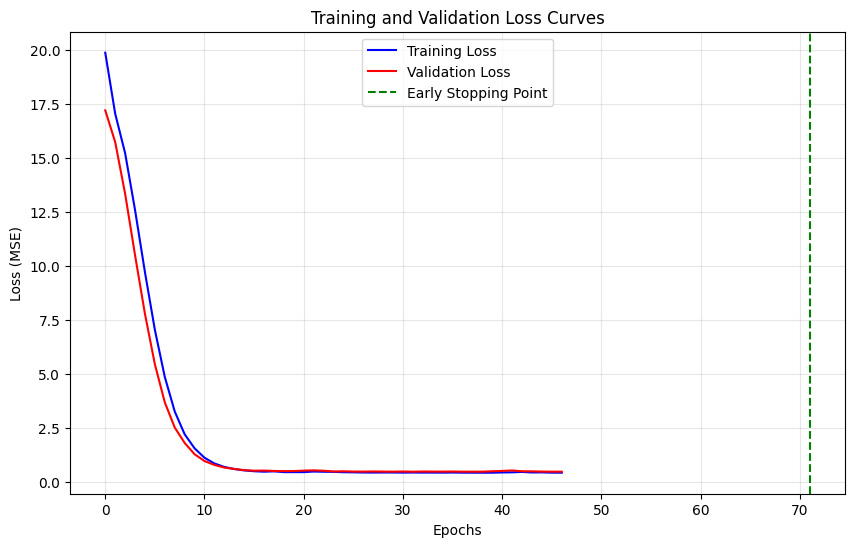

In [17]:
# Plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 6))  # Initialise figure and axes
ax.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax.plot(range(len(test_losses)), test_losses, label="Validation Loss", color="red")
ax.axvline(x=71, color="green", linestyle="--", label="Early Stopping Point")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Training and Validation Loss Curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [18]:
# Evaluate model performance
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Calculate overall metrics
r2 = r2_score(all_targets.flatten(), all_predictions.flatten())
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
mae = mean_absolute_error(all_targets, all_predictions)
evs = explained_variance_score(all_targets.flatten(), all_predictions.flatten())

print(f"Overall Model Performance:")
print(f"R-squared (R²): {r2:.4f}")  # compares residual sum of squaress to total sum of squares
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Explained Variance Score: {evs:.4f}")  # variance of residuals

Overall Model Performance:
R-squared (R²): 0.8396
Root Mean Squared Error (RMSE): 0.6909
Mean Absolute Error (MAE): 0.5042
Explained Variance Score: 0.8399


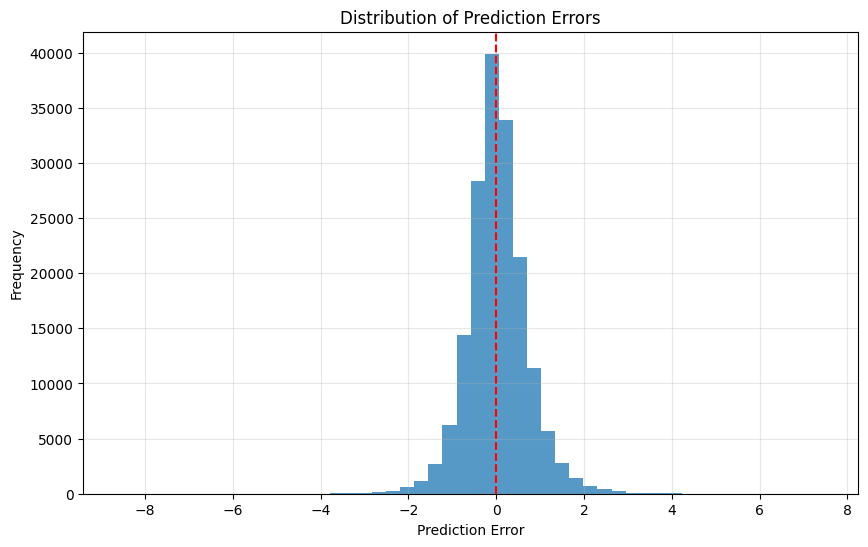

In [19]:
# Plot error distribution
fig, ax = plt.subplots(figsize=(10, 6))  # Initialise figure and axes
errors = (all_predictions - all_targets).flatten()
ax.hist(errors, bins=50, alpha=0.75)
ax.axvline(x=0, color="red", linestyle="--")
ax.set_xlabel("Prediction Error")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Prediction Errors")
ax.grid(True, alpha=0.3)
plt.show()

# Baseline MLP Results <a id="results-MLP"></a>

The MLP is performing quite well already, with R^2 of ~0.83 and the error distribution normally distributed. The errors look Normally distributed, so the MLP is already performing well without systematically overestimating/underestimating the target values. 

# Transformer <a id="transformer-models"></a> 

This part is the development of the Transformer model. The Transformer model is designed so that it can be used to iteratively scan through different combinations of input omics data, fusion strategies, activation function (only ReLU and GeLU, as I'm working with PyTorch), and for hyperparameter optimisation.

In [20]:
class ModularMultiOmicsTransformer(nn.Module):
    def __init__(self, input_dims, output_dim, num_heads=8, num_layers=4, 
                 hidden_dim=256, dropout_rate=0.1, fusion_method="hierarchical",
                 activation_function="gelu"):
        """
        Modular Transformer-based model with various fusion strategies and configurable activation
        
        Args:
            input_dims: Dictionary mapping omics type to its feature dimension
            output_dim: Number of proteomics features to predict
            fusion_method: One of ["hierarchical", "late", "gated", "weighted", "cross_attention"]
            activation_function: One of ["gelu", "relu"]. PyTorch only allows relu or gelu.
        """
        super(ModularMultiOmicsTransformer, self).__init__()
        
        self.fusion_method = fusion_method
        self.num_modalities = len(input_dims)
        
        # Get the specified activation function
        self.activation = self._get_activation_function(activation_function)
        
        # Create an embedding layer for each omics type
        self.embeddings = nn.ModuleDict({
            omics_type: nn.Sequential(
                nn.Linear(dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                self.activation
            ) for omics_type, dim in input_dims.items()
        })
        
        # Create separate transformer encoders for each modality
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout_rate,
            activation=activation_function,
            batch_first=True,
            norm_first=True
        )
        
        self.modality_transformers = nn.ModuleDict({
            omics_type: nn.TransformerEncoder(
                encoder_layer, 
                num_layers=2
            ) for omics_type in input_dims.keys()
        })
        
        # Generate positional encodings once
        self.register_buffer(
            "pos_encoding", 
            self._generate_positional_encoding(len(input_dims), hidden_dim)
        )
        
        # Type embeddings for all fusion methods
        self.type_embeddings = nn.Embedding(len(input_dims), hidden_dim)
        
        # Fusion-specific modules
        if fusion_method == "hierarchical":
            # For hierarchical fusion: modality -> joint processing
            self.joint_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            
        elif fusion_method == "late":
            # For late fusion: process each modality separately, then combine
            self.fusion_layer = nn.Linear(hidden_dim * len(input_dims), hidden_dim)
            
        elif fusion_method == "gated":
            # For gated fusion: learn importance of each modality
            self.gate_networks = nn.ModuleDict({
                omics_type: nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    self.activation,
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.Sigmoid()
                ) for omics_type in input_dims.keys()
            })
            
        elif fusion_method == "weighted":
            # For weighted fusion: learn a weight for each modality
            self.modality_weights = nn.Parameter(torch.ones(len(input_dims)) / len(input_dims))
            self.softmax = nn.Softmax(dim=0)
            
        elif fusion_method == "cross_attention":
            # For cross-attention: joint transformer with attention pooling
            self.joint_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self.attention_pooling = nn.Sequential(
                nn.Linear(hidden_dim, 1),
                nn.Softmax(dim=1)
            )
        
        # Final prediction layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),  # expand dimensionality to capture more complex interactions in data
            nn.LayerNorm(hidden_dim * 2), # normalise activations of preveious layer
            self.activation,  # activation function (ReLU or GeLU)
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),  # reduce dimensionality back, i.e. focus on most important patterns
            nn.LayerNorm(hidden_dim), # normalise
            self.activation,  # activation function (ReLU or GeLU)
            nn.Dropout(dropout_rate/2), # smaller dropout rate to retain more info for the final prediction
        )
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self._init_weights()
    
    def _get_activation_function(self, name):
        """Return the activation function based on name"""
        activations = {
            "gelu": nn.GELU(),
            "relu": nn.ReLU(),
        }
        return activations.get(name.lower(), nn.GELU())
        
    def _generate_positional_encoding(self, seq_len, d_model):
        """Generate positional encodings for the Transformer"""
        pos_encoding = torch.zeros(1, seq_len, d_model)
        position = torch.arange(0, seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pos_encoding[0, :, 0::2] = torch.sin(position * div_term)
        pos_encoding[0, :, 1::2] = torch.cos(position * div_term)
        
        return pos_encoding
    
    def _init_weights(self):
        """Initialise weights using Xavier/Glorot initialisation"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x_dict):
        """
        Forward pass
        
        Args:
            x_dict: Dictionary mapping omics type to tensor of shape [batch_size, features]
        """
        # Determine batch size of input data. As this will be used for various combinations of input data.
        batch_size = next(iter(x_dict.values())).size(0)
        
        # Process each modality separately first
        modality_features = {}
        embedded_features = []
        modality_indices = []
        for i, (omics_type, x) in enumerate(x_dict.items()):
            
            # Embed to common dimension
            embedded = self.embeddings[omics_type](x)  # [batch_size, hidden_dim]
            embedded = embedded.unsqueeze(1)  # [batch_size, 1, hidden_dim]
            
            # Store for fusion methods that need individual modality features
            modality_features[omics_type] = embedded.squeeze(1)  # [batch_size, hidden_dim]
            
            # Store for fusion methods that need concatenated features
            embedded_features.append(embedded)
            modality_indices.append(i)
            
            # Process with modality-specific transformer if not using cross_attention
            if self.fusion_method != "cross_attention":
                transformed = self.modality_transformers[omics_type](embedded)
                # Squeeze to remove sequence dimension (only 1 token per modality)
                modality_features[omics_type] = transformed.squeeze(1)  # [batch_size, hidden_dim]
        
        # Apply fusion method
        if self.fusion_method == "hierarchical" or self.fusion_method == "cross_attention":
            # Concatenate along sequence dimension
            x = torch.cat(embedded_features, dim=1)  # [batch_size, num_omics, hidden_dim]
            
            # Add positional encoding and type embeddings
            type_ids = torch.tensor(modality_indices, device=x.device).expand(batch_size, -1)
            type_embeds = self.type_embeddings(type_ids)
            x = x + self.pos_encoding.to(x.device) + type_embeds
            
            # Apply joint transformer
            x = self.joint_transformer(x)  # [batch_size, num_omics, hidden_dim]
            
            if self.fusion_method == "hierarchical":
                # Take average of all modality representations
                fused = torch.mean(x, dim=1)  # [batch_size, hidden_dim]
            else:  # cross_attention
                # Use attention pooling
                attn_weights = self.attention_pooling(x)  # [batch_size, num_omics, 1]
                fused = torch.sum(x * attn_weights, dim=1)  # [batch_size, hidden_dim]
            
        elif self.fusion_method == "late":
            # Concatenate all modality features
            concatenated = torch.cat([
                modality_features[omics_type] for omics_type in x_dict.keys()
            ], dim=1)  # [batch_size, hidden_dim * num_omics]
            
            # Project back to hidden_dim
            fused = self.fusion_layer(concatenated)  # [batch_size, hidden_dim]
            
        elif self.fusion_method == "gated":
            # Apply gates to each modality
            gated_features = []
            for omics_type in x_dict.keys():
                gate = self.gate_networks[omics_type](modality_features[omics_type])
                gated = modality_features[omics_type] * gate
                gated_features.append(gated)
            
            # Sum all gated features
            fused = sum(gated_features)  # [batch_size, hidden_dim]
            
        elif self.fusion_method == "weighted":
            # Apply learned weights to each modality
            weights = self.softmax(self.modality_weights)
            
            weighted_sum = None
            for i, omics_type in enumerate(x_dict.keys()):
                if weighted_sum is None:
                    weighted_sum = weights[i] * modality_features[omics_type]
                else:
                    weighted_sum += weights[i] * modality_features[omics_type]
            
            fused = weighted_sum  # [batch_size, hidden_dim]
        
        # Final prediction
        features = self.fc_layers(fused)
        output = self.output_layer(features)
        
        return output

## Hyperparameter Tuning <a id="hyperparameter-tuning"></a> 

In [21]:
def prepare_data_loaders(omics_set, datasets=None, target_dataset="proteomics", test_size=0.2, 
                         batch_size=32, random_state=42, val_split=0.1):
    """
    Create data loaders for multi-omics integration that can handle any combination of input omics data.
    
    Parameters:
    -----------
    omics_set : list
        List of strings specifying which omics datasets to use as input (e.g., ["methylation", "transcriptomics"])
    datasets : dict
        Dictionary containing pandas DataFrames for each omics dataset (if None, global datasets dict is used)
    target_dataset : str, default="proteomics"
        The omics dataset to predict (target)
    test_size : float, default=0.2
        Proportion of data to use for testing
    batch_size : int, default=32
        Batch size for data loaders
    random_state : int, default=42
        Random seed for reproducibility
    val_split : float, default=0.1
        Proportion of training data to use for validation
        
    Returns:
    --------
    train_loader : DataLoader
        DataLoader for training data
    val_loader : DataLoader
        DataLoader for validation data
    test_loader : DataLoader
        DataLoader for test data
    input_dims : dict
        Dictionary mapping each omics type to its dimensionality
    output_dim : int
        Dimensionality of the target dataset
    """
    
    # Use global datasets if none provided
    if datasets is None:
        # This assumes "datasets" is defined globally
        try:
            datasets = globals()["datasets"]
        except KeyError:
            raise ValueError("No datasets provided and no global \"datasets\" dictionary found")
    
    # Extract features and targets
    X_dict = {}
    for dataset_name in omics_set:
        if dataset_name in datasets:
            X_dict[dataset_name] = datasets[dataset_name].iloc[:, 1:].values  # Exclude patient ID column
        else:
            raise ValueError(f"Dataset \"{dataset_name}\" not found in provided datasets")
    
    y = datasets[target_dataset].iloc[:, 1:].values
    
    # Create input dimensions dictionary
    input_dims = {dataset_name: X_dict[dataset_name].shape[1] for dataset_name in omics_set}
    output_dim = y.shape[1]
    
    # Define the dataset class
    class MultiOmicsDataset(Dataset):
        def __init__(self, X_dict, y):
            self.X_dict = {k: torch.FloatTensor(v) for k, v in X_dict.items()}
            self.y = torch.FloatTensor(y)
            
        def __len__(self):
            # Assuming all X datasets have the same length
            return len(next(iter(self.X_dict.values())))
        
        def __getitem__(self, idx):
            # Return a dictionary for X, where each key is a dataset name
            return {k: v[idx] for k, v in self.X_dict.items()}, self.y[idx]
    
    # Get indices for train/test split (#TODO: perform cross-validation later)
    n_samples = len(y)
    indices = np.arange(n_samples)
    train_val_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
    
    # Further split training data into train and validation
    if val_split > 0:
        train_indices, val_indices = train_test_split(
            train_val_indices, test_size=val_split/(1-test_size), random_state=random_state
        )
        
        # Create validation set
        X_val_dict = {k: v[val_indices] for k, v in X_dict.items()}
        y_val = y[val_indices]
        val_dataset = MultiOmicsDataset(X_val_dict, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        train_indices = train_val_indices
        val_loader = None
    
    # Split each dataset using the indices
    X_train_dict = {k: v[train_indices] for k, v in X_dict.items()}
    X_test_dict = {k: v[test_indices] for k, v in X_dict.items()}
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    # Create datasets and dataloaders
    train_dataset = MultiOmicsDataset(X_train_dict, y_train)
    test_dataset = MultiOmicsDataset(X_test_dict, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, input_dims, output_dim

In [22]:
def optimise_hyperparams(omics_set, n_trials=30):
    """
    Optimise hyperparameters for specific combination of omics data
    
    Parameters:
    -----------
    omics_set : list
        List of omics types to include
    n_trials : int
        Number of optimisation trials
        
    Returns:
    --------
    best_params : dict
        Dictionary of best hyperparameters
    """
    print(f"\n{'='*80}")
    print(f"Optimising hyperparameters for omics set: {omics_set}")
    print(f"{'='*80}")
    
    # Prepare data loaders with the selected omics types
    train_loader, val_loader, test_loader, input_dims, output_dim = prepare_data_loaders(omics_set)
    
    # Number of epochs for each trial
    epochs = 50
    
    # Define the Optuna objective function
    def objective(trial):
        # Suggest hyperparameters
        num_heads = trial.suggest_categorical("num_heads", [4, 8, 16])
        num_layers = trial.suggest_int("num_layers", 2, 6)
        hidden_dim = trial.suggest_int("hidden_dim", 128, 512, step=64)
        dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        
        # Additional hyperparameters for ModularMultiOmicsTransformer
        fusion_method = trial.suggest_categorical("fusion_method", 
                                                ["hierarchical", "late", "gated", "weighted", "cross_attention"])
        activation_function = trial.suggest_categorical("activation_function", 
                                                     ["gelu", "relu"])
        
        # Instantiate the model with the suggested hyperparameters
        model = ModularMultiOmicsTransformer(
            input_dims=input_dims,
            output_dim=output_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            fusion_method=fusion_method,
            activation_function=activation_function
        ).to(device)
        
        # Define loss function and optimiser
        criterion = nn.MSELoss()
        optimiser = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        # Define the learning rate scheduler
        lr_scheduler = CosineAnnealingLR(
            optimiser,
            T_max=epochs,
            eta_min=1e-6
        )
        
        # Training loop
        best_val_loss = float("inf")
        patience = 10
        counter = 0
        early_stop = False
        for epoch in range(epochs):
            if early_stop:
                break
                
            # Training phase
            model.train()
            running_loss = 0.0
            for inputs_dict, targets in train_loader:
                inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
                targets = targets.to(device)
                
                optimiser.zero_grad()
                outputs = model(inputs_dict)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimiser.step()
                
                running_loss += loss.item() * targets.size(0)
            
            lr_scheduler.step()
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs_dict, targets in val_loader:
                    inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
                    targets = targets.to(device)
                    
                    outputs = model(inputs_dict)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * targets.size(0)
            
            epoch_val_loss = val_loss / len(val_loader.dataset)
            
            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                counter = 0
            else:
                counter += 1
            
            if counter >= patience:
                early_stop = True
        
        return best_val_loss

    # Run Optuna optimisation
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    
    # Get best hyperparameters
    best_params = study.best_params
    print("\nBest hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Check optimisation history 
    print(f"\nBest validation loss: {study.best_value:.6f}")
    
    return best_params

In [23]:
def train_and_evaluate(omics_set, best_params):
    """
    Train and evaluate the model with the best hyperparameters for specific omics combination
    
    Parameters:
    -----------
    omics_set : list
        List of omics types to include
    best_params : dict
        Dictionary of best hyperparameters
        
    Returns:
    --------
    results : dict
        Dictionary containing performance metrics and training history
    """
    print(f"\n{'-'*80}")
    print(f"Training final model for omics set: {omics_set}")
    print(f"{'-'*80}")
    
    epochs = 200
    
    train_loader, val_loader, test_loader, input_dims, output_dim = prepare_data_loaders(omics_set)
    
    # Use the best hyperparameters to instantiate the model
    model = ModularMultiOmicsTransformer(
        input_dims=input_dims,
        output_dim=output_dim,
        num_heads=best_params["num_heads"],
        num_layers=best_params["num_layers"],
        hidden_dim=best_params["hidden_dim"],
        dropout_rate=best_params["dropout_rate"],
        fusion_method=best_params["fusion_method"],
        activation_function=best_params["activation_function"]
    ).to(device)
    
    # Loss function and optimiser
    criterion = nn.MSELoss()
    optimiser = optim.AdamW(
        model.parameters(),
        lr=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"]
    )
    
    # Learning rate scheduler
    lr_scheduler = CosineAnnealingLR(
        optimiser,
        T_max=epochs,
        eta_min=1e-6
    )
    
    # Training loop
    best_val_loss = float("inf")
    patience = 20  # Slightly more patience for final model
    counter = 0
    train_losses = []
    val_losses = []
    best_model_state = None
    early_stop_epoch = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs_dict, targets in train_loader:
            inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
            targets = targets.to(device)
            
            optimiser.zero_grad()
            outputs = model(inputs_dict)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimiser.step()
            
            running_loss += loss.item() * targets.size(0)
        
        lr_scheduler.step()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs_dict, targets in val_loader:
                inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
                targets = targets.to(device)
                
                outputs = model(inputs_dict)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * targets.size(0)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
            early_stop_epoch = epoch
        else:
            counter += 1
            
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Print progress periodically
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
            print(f"Learning rate: {optimiser.param_groups[0]['lr']:.6f}")
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    
    # Save the trained model
    model_name = f"best_model_{'_'.join(omics_set)}.pth"
    torch.save(model.state_dict(), model_path / model_name)
    
    # Evaluate model on test set
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs_dict, targets in test_loader:
            inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
            targets = targets.to(device)
            
            outputs = model(inputs_dict)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate overall metrics
    r2 = r2_score(all_targets.flatten(), all_predictions.flatten())
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    evs = explained_variance_score(all_targets.flatten(), all_predictions.flatten())
    
    # Store results
    results = {
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae, 
        "EVS": evs,
        "Best_Val_Loss": best_val_loss,
        "Hyperparameters": best_params,
        "Train_Losses": train_losses,
        "Val_Losses": val_losses,
        "Early_Stop_Epoch": early_stop_epoch
    }
    
    print(f"\nPerformance for omics set {omics_set}:")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Explained Variance Score: {evs:.4f}")
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="red")
    plt.axvline(x=early_stop_epoch, color="green", linestyle="--", label="Early Stopping Point")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title(f"Learning Curves for Omics Combination: {'+'.join(omics_set)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Progressive Input Omics Selection <a id="omics-selection"></a> 

In [24]:
def progressive_omics_selection(omics_types, n_trials=30):
    """
    Progressively select the best combination of input omics types
    
    Parameters:
    -----------
    omics_types : list
        List of all available omics types
    n_trials : int
        Number of optimisation trials per combination
        
    Returns:
    --------
    all_results : dict
        Dictionary containing results for all tested combinations
    current_set : list
        Best combination of omics types
    """
    # Start with the best single modality (transcriptomics)
    current_set = ["transcriptomics"]
    all_results = {}
    
    # Get the baseline performance with just transcriptomics
    best_params = optimise_hyperparams(current_set, n_trials=n_trials)
    results = train_and_evaluate(current_set, best_params)
    all_results[tuple(current_set)] = results
    best_r2 = results["R2"]
    
    print(f"\nBaseline with {current_set}: R² = {best_r2:.4f}")
    
    # Track progress in a dataframe for better viewing
    progress_df = pd.DataFrame([{
        "Step": 0,
        "Current Set": "+".join(current_set),
        "R²": best_r2,
        "RMSE": results["RMSE"]
    }])
    
    display(HTML("<h3>Progressive Selection Progress</h3>"))
    display(progress_df)
    
    # Progressively add one modality at a time
    step = 1
    for _ in range(len(omics_types) - 1):
        candidate_results = {}
        step_df = []
        
        # Try adding each remaining modality
        for omics in omics_types:
            if omics not in current_set:
                test_set = current_set + [omics]
                print(f"\nTesting omics set: {test_set}")
                
                # Optimise hyperparameters for this combination
                best_params = optimise_hyperparams(test_set, n_trials=n_trials)
                
                # Train and evaluate with best hyperparameters
                results = train_and_evaluate(test_set, best_params)
                candidate_results[omics] = results
                all_results[tuple(test_set)] = results
                
                step_df.append({
                    "Added Omics": omics,
                    "Test Set": "+".join(test_set),
                    "R²": results["R2"],
                    "RMSE": results["RMSE"],
                    "Improvement": results["R2"] - best_r2
                })
                
                print(f"Adding {omics} → R² = {results['R2']:.4f} (Δ = {results['R2'] - best_r2:+.4f})")
        
        # Display this step's results
        step_df = pd.DataFrame(step_df)
        display(HTML(f"<h4>Step {step} - Candidate Additions</h4>"))
        display(step_df.sort_values("R²", ascending=False))
        
        # Find best modality to add
        best_omics = max(candidate_results, key=lambda x: candidate_results[x]["R2"])
        if candidate_results[best_omics]["R2"] > best_r2:
            current_set.append(best_omics)
            best_r2 = candidate_results[best_omics]["R2"]
            print(f"\nAdded {best_omics}. New best set: {current_set}, R²: {best_r2:.4f}")
            
            # Update progress
            progress_df = pd.concat([
                progress_df,
                pd.DataFrame([{
                    "Step": step,
                    "Current Set": "+".join(current_set),
                    "R²": best_r2,
                    "RMSE": candidate_results[best_omics]["RMSE"],
                    "Added": best_omics
                }])
            ])
            
            display(HTML("<h3>Updated Progressive Selection Progress</h3>"))
            display(progress_df)
            
            step += 1
        else:
            print(f"\nNo further improvement. Best set: {current_set}, R²: {best_r2:.4f}")
            break
    
    # Plot progression of performance
    plt.figure(figsize=(10, 6))
    plt.plot(progress_df["Step"], progress_df["R²"], "o-", color="blue", linewidth=2, markersize=8)
    plt.xlabel("Selection Step")
    plt.ylabel("R² Score")
    plt.title("Progression of Model Performance")
    plt.grid(True, alpha=0.3)
    for i, row in progress_df.iterrows():
        if i > 0:  # Skip first point (no addition)
            plt.annotate(f"+{row['Added']}", 
                        (row["Step"], row["R²"]),
                        xytext=(10, 0), 
                        textcoords="offset points",
                        fontsize=10,
                        fontweight="bold")
    plt.tight_layout()
    plt.show()
    
    return all_results, current_set, progress_df

# Evaluation Loop <a id="evaluation-loop"></a>

In [25]:
def summarise_results(all_results, best_set):
    
    # Create summary table
    summary = []
    for omics_set, results in all_results.items():
        summary.append({
            "Omics Set": "+".join(omics_set),
            "R2": results["R2"],
            "RMSE": results["RMSE"],
            "MAE": results["MAE"],
            "EVS": results["EVS"],
            "Fusion Method": results["Hyperparameters"].get("fusion_method", "N/A"),
            "Activation": results["Hyperparameters"].get("activation_function", "N/A")
        })
    
    # Sort by R2 score
    summary_sorted = sorted(summary, key=lambda x: x["R2"], reverse=True)
    
    print("\n\n===== SUMMARY OF ALL COMBINATIONS =====")
    print(f"{'Omics Set':<30} {'R²':<10} {'RMSE':<10} {'MAE':<10} {'EVS':<10} {'Fusion':<15} {'Activation':<10}")
    print("-" * 90)
    for entry in summary_sorted:
        print(f"{entry['Omics Set']:<30} {entry['R2']:<10.4f} {entry['RMSE']:<10.4f} {entry['MAE']:<10.4f} "
              f"{entry['EVS']:<10.4f} {entry['Fusion Method']:<15} {entry['Activation']:<10}")
    
    # Plot performance metrics for different combinations
    plt.figure(figsize=(12, 8))
    
    # Extract data for plotting
    combinations = ["+".join(comb) for comb in all_results.keys()]
    r2_values = [results["R2"] for results in all_results.values()]
    rmse_values = [results["RMSE"] for results in all_results.values()]
    
    # Sort by performance
    sorted_indices = np.argsort(r2_values)[::-1]
    combinations = [combinations[i] for i in sorted_indices]
    r2_values = [r2_values[i] for i in sorted_indices]
    rmse_values = [rmse_values[i] for i in sorted_indices]
    
    x = np.arange(len(combinations))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twinx()
    
    # Plot R^2 (higher is better)
    bars1 = ax1.bar(x - width/2, r2_values, width, label="R²", color="blue", alpha=0.7)
    ax1.set_ylabel("R² Score (higher is better)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_ylim(0, max(r2_values) * 1.1)
    
    # Plot RMSE (lower is better)
    bars2 = ax2.bar(x + width/2, rmse_values, width, label="RMSE", color="red", alpha=0.7)
    ax2.set_ylabel("RMSE (lower is better)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(0, max(rmse_values) * 1.1)
    
    # Highlight the best combination
    best_idx = combinations.index("+".join(best_set))
    bars1[best_idx].set_color("darkblue")
    bars1[best_idx].set_alpha(1.0)
    bars2[best_idx].set_color("darkred")
    bars2[best_idx].set_alpha(1.0)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(combinations, rotation=45, ha="right")
    ax1.set_title("Performance Comparison of Different Omics Combinations")
    
    # Add legends
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()
    
    # Plot learning curves for the best combination
    best_results = all_results[tuple(best_set)]
    plt.figure(figsize=(10, 6))
    plt.plot(best_results["Train_Losses"], label="Training Loss", color="blue")
    plt.plot(best_results["Val_Losses"], label="Validation Loss", color="red")
    plt.axvline(x=best_results["Early_Stop_Epoch"], color="green", linestyle="--", label="Early Stopping Point")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title(f"Learning Curves for Best Omics Combination: {'+'.join(best_set)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Analyse fusion methods and activations
    fusion_methods = [results["Hyperparameters"].get("fusion_method") for results in all_results.values()]
    fusion_methods = [m for m in fusion_methods if m is not None]
    
    if len(fusion_methods) > 0:
        plt.figure(figsize=(10, 6))
        fusion_counts = pd.Series(fusion_methods).value_counts()
        plt.bar(fusion_counts.index, fusion_counts.values)
        plt.title("Frequency of Fusion Methods in Top Performing Models")
        plt.xlabel("Fusion Method")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    
    return summary_sorted

[I 2025-04-06 17:51:45,986] A new study created in memory with name: no-name-aa613313-6948-426f-b5f1-36ce57112707



Optimising hyperparameters for omics set: ['transcriptomics']


[I 2025-04-06 17:51:48,633] Trial 0 finished with value: 0.3813028335571289 and parameters: {'num_heads': 8, 'num_layers': 2, 'hidden_dim': 448, 'dropout_rate': 0.1, 'learning_rate': 0.0007686258777896336, 'weight_decay': 0.00031232835331080705, 'fusion_method': 'weighted', 'activation_function': 'relu'}. Best is trial 0 with value: 0.3813028335571289.
[I 2025-04-06 17:51:50,577] Trial 1 finished with value: 0.3810807168483734 and parameters: {'num_heads': 4, 'num_layers': 4, 'hidden_dim': 448, 'dropout_rate': 0.0, 'learning_rate': 0.0008530624208785767, 'weight_decay': 2.7423954610258884e-06, 'fusion_method': 'gated', 'activation_function': 'gelu'}. Best is trial 1 with value: 0.3810807168483734.
[I 2025-04-06 17:51:53,257] Trial 2 finished with value: 0.7077482342720032 and parameters: {'num_heads': 16, 'num_layers': 2, 'hidden_dim': 448, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002469527769359927, 'weight_decay': 0.00020368844597541314, 'fusion_method': 'late', 'acti


Best hyperparameters:
  num_heads: 4
  num_layers: 6
  hidden_dim: 384
  dropout_rate: 0.1
  learning_rate: 0.0009052341259832195
  weight_decay: 1.1016969061267455e-06
  fusion_method: gated
  activation_function: relu

Best validation loss: 0.380767

--------------------------------------------------------------------------------
Training final model for omics set: ['transcriptomics']
--------------------------------------------------------------------------------
Epoch 0/200, Train Loss: 16.1129, Val Loss: 13.3567
Learning rate: 0.000905
Epoch 10/200, Train Loss: 0.6355, Val Loss: 0.5044
Learning rate: 0.000899
Epoch 20/200, Train Loss: 0.4696, Val Loss: 0.3838
Learning rate: 0.000881
Epoch 30/200, Train Loss: 0.4693, Val Loss: 0.3799
Learning rate: 0.000853
Epoch 40/200, Train Loss: 0.4703, Val Loss: 0.3817
Learning rate: 0.000815
Epoch 50/200, Train Loss: 0.4705, Val Loss: 0.3817
Learning rate: 0.000768
Epoch 60/200, Train Loss: 0.4724, Val Loss: 0.3822
Learning rate: 0.000713
Ep

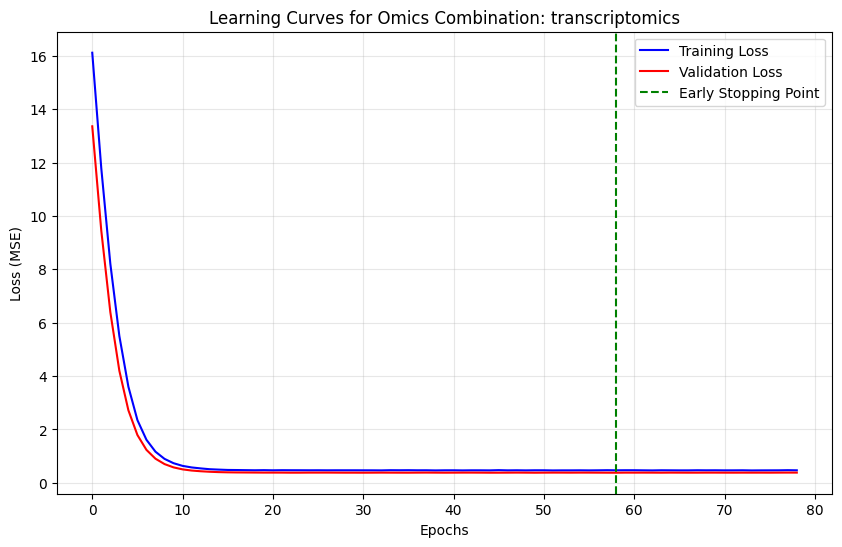


Baseline with ['transcriptomics']: R² = 0.8379


,Step,Current Set,R²,RMSE
0,0,transcriptomics,0.837898,0.694606


[I 2025-04-06 17:52:50,103] A new study created in memory with name: no-name-45c5df93-7cfa-4c16-9671-81f6062478a5



Testing omics set: ['transcriptomics', 'methylation']

Optimising hyperparameters for omics set: ['transcriptomics', 'methylation']


[I 2025-04-06 17:52:53,957] Trial 0 finished with value: 1.6818805932998657 and parameters: {'num_heads': 4, 'num_layers': 2, 'hidden_dim': 384, 'dropout_rate': 0.4, 'learning_rate': 0.0001993699994714653, 'weight_decay': 0.00027791171185811763, 'fusion_method': 'hierarchical', 'activation_function': 'gelu'}. Best is trial 0 with value: 1.6818805932998657.
[I 2025-04-06 17:52:58,974] Trial 1 finished with value: 0.3847963511943817 and parameters: {'num_heads': 4, 'num_layers': 2, 'hidden_dim': 320, 'dropout_rate': 0.1, 'learning_rate': 0.0006982625262066497, 'weight_decay': 3.5203116305699338e-06, 'fusion_method': 'weighted', 'activation_function': 'gelu'}. Best is trial 1 with value: 0.3847963511943817.
[I 2025-04-06 17:53:03,574] Trial 2 finished with value: 0.5897822976112366 and parameters: {'num_heads': 16, 'num_layers': 6, 'hidden_dim': 512, 'dropout_rate': 0.2, 'learning_rate': 0.00023532068850223126, 'weight_decay': 6.208279321666879e-06, 'fusion_method': 'late', 'activation_fu


Best hyperparameters:
  num_heads: 4
  num_layers: 5
  hidden_dim: 512
  dropout_rate: 0.1
  learning_rate: 0.0006088847908661561
  weight_decay: 1.919013761102395e-06
  fusion_method: cross_attention
  activation_function: relu

Best validation loss: 0.380768

--------------------------------------------------------------------------------
Training final model for omics set: ['transcriptomics', 'methylation']
--------------------------------------------------------------------------------
Epoch 0/200, Train Loss: 16.2218, Val Loss: 13.7426
Learning rate: 0.000609
Epoch 10/200, Train Loss: 0.7191, Val Loss: 0.5666
Learning rate: 0.000604
Epoch 20/200, Train Loss: 0.4690, Val Loss: 0.3829
Learning rate: 0.000592
Epoch 30/200, Train Loss: 0.4656, Val Loss: 0.3816
Learning rate: 0.000574
Epoch 40/200, Train Loss: 0.4692, Val Loss: 0.3817
Learning rate: 0.000548
Epoch 50/200, Train Loss: 0.4673, Val Loss: 0.3832
Learning rate: 0.000516
Epoch 60/200, Train Loss: 0.4671, Val Loss: 0.3811
Le

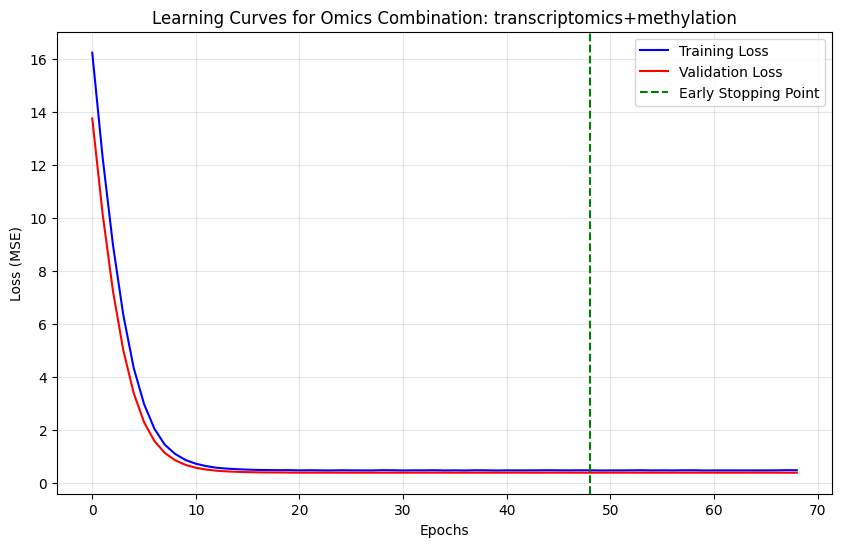

[I 2025-04-06 17:54:33,769] A new study created in memory with name: no-name-4586b675-6eb6-42e8-a707-0ae23ecb8354


Adding methylation → R² = 0.8373 (Δ = -0.0006)

Testing omics set: ['transcriptomics', 'metabolomics']

Optimising hyperparameters for omics set: ['transcriptomics', 'metabolomics']


[I 2025-04-06 17:54:38,530] Trial 0 finished with value: 15.8047456741333 and parameters: {'num_heads': 16, 'num_layers': 6, 'hidden_dim': 512, 'dropout_rate': 0.5, 'learning_rate': 1.0641387495309008e-05, 'weight_decay': 2.4775688659191966e-06, 'fusion_method': 'late', 'activation_function': 'gelu'}. Best is trial 0 with value: 15.8047456741333.
[I 2025-04-06 17:54:43,087] Trial 1 finished with value: 3.7341461181640625 and parameters: {'num_heads': 8, 'num_layers': 5, 'hidden_dim': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0004519794436856921, 'weight_decay': 0.00022493328770177554, 'fusion_method': 'late', 'activation_function': 'gelu'}. Best is trial 1 with value: 3.7341461181640625.
[I 2025-04-06 17:54:48,572] Trial 2 finished with value: 0.7684175372123718 and parameters: {'num_heads': 8, 'num_layers': 4, 'hidden_dim': 448, 'dropout_rate': 0.1, 'learning_rate': 0.0002572019072386416, 'weight_decay': 0.0002509318609291807, 'fusion_method': 'gated', 'activation_function': 'relu'


Best hyperparameters:
  num_heads: 16
  num_layers: 6
  hidden_dim: 384
  dropout_rate: 0.30000000000000004
  learning_rate: 0.000972305604510177
  weight_decay: 0.00038894452390234995
  fusion_method: cross_attention
  activation_function: relu

Best validation loss: 0.380669

--------------------------------------------------------------------------------
Training final model for omics set: ['transcriptomics', 'metabolomics']
--------------------------------------------------------------------------------
Epoch 0/200, Train Loss: 16.0221, Val Loss: 13.0135
Learning rate: 0.000972
Epoch 10/200, Train Loss: 0.6344, Val Loss: 0.4826
Learning rate: 0.000965
Epoch 20/200, Train Loss: 0.5022, Val Loss: 0.3817
Learning rate: 0.000946
Epoch 30/200, Train Loss: 0.4947, Val Loss: 0.3816
Learning rate: 0.000916
Epoch 40/200, Train Loss: 0.4951, Val Loss: 0.3815
Learning rate: 0.000875
Epoch 50/200, Train Loss: 0.4933, Val Loss: 0.3816
Learning rate: 0.000825
Epoch 60/200, Train Loss: 0.4941, V

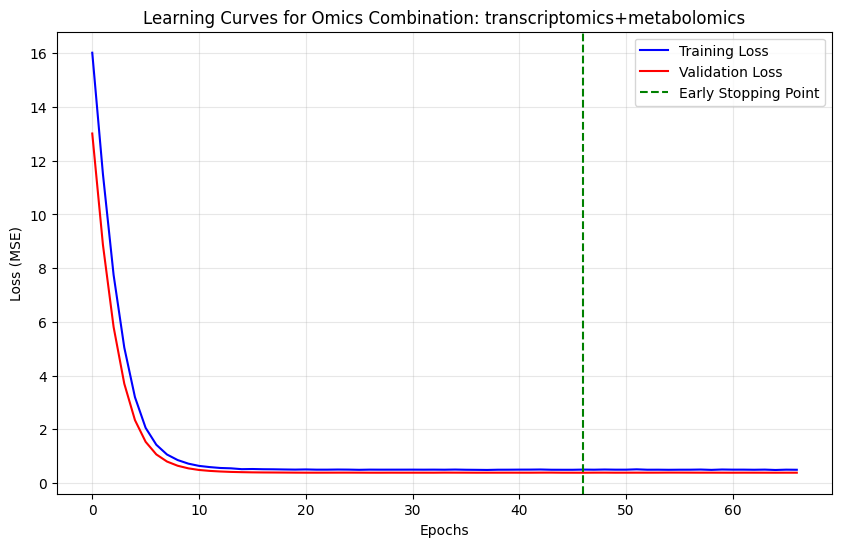

[I 2025-04-06 17:56:20,909] A new study created in memory with name: no-name-4e76ec40-f0c5-4507-9619-e2066d6c874b


Adding metabolomics → R² = 0.8372 (Δ = -0.0007)

Testing omics set: ['transcriptomics', 'cnv']

Optimising hyperparameters for omics set: ['transcriptomics', 'cnv']


[I 2025-04-06 17:56:25,565] Trial 0 finished with value: 13.654505729675293 and parameters: {'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'dropout_rate': 0.0, 'learning_rate': 3.967998267640179e-05, 'weight_decay': 2.817608065890305e-06, 'fusion_method': 'late', 'activation_function': 'gelu'}. Best is trial 0 with value: 13.654505729675293.
[I 2025-04-06 17:56:32,205] Trial 1 finished with value: 0.38094860315322876 and parameters: {'num_heads': 4, 'num_layers': 6, 'hidden_dim': 512, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.000673079167996951, 'weight_decay': 0.00034626547810351593, 'fusion_method': 'hierarchical', 'activation_function': 'relu'}. Best is trial 1 with value: 0.38094860315322876.
[I 2025-04-06 17:56:36,560] Trial 2 finished with value: 0.39312463998794556 and parameters: {'num_heads': 16, 'num_layers': 3, 'hidden_dim': 512, 'dropout_rate': 0.2, 'learning_rate': 0.00040326782816551486, 'weight_decay': 3.4732814786739874e-05, 'fusion_method': 'late', 


Best hyperparameters:
  num_heads: 4
  num_layers: 6
  hidden_dim: 512
  dropout_rate: 0.4
  learning_rate: 0.0006904484198867675
  weight_decay: 0.0008079568570897727
  fusion_method: hierarchical
  activation_function: relu

Best validation loss: 0.379996

--------------------------------------------------------------------------------
Training final model for omics set: ['transcriptomics', 'cnv']
--------------------------------------------------------------------------------
Epoch 0/200, Train Loss: 16.0832, Val Loss: 13.1975
Learning rate: 0.000690
Epoch 10/200, Train Loss: 0.6679, Val Loss: 0.4989
Learning rate: 0.000685
Epoch 20/200, Train Loss: 0.5079, Val Loss: 0.3831
Learning rate: 0.000672
Epoch 30/200, Train Loss: 0.5030, Val Loss: 0.3807
Learning rate: 0.000650
Epoch 40/200, Train Loss: 0.5114, Val Loss: 0.3819
Learning rate: 0.000621
Epoch 50/200, Train Loss: 0.5049, Val Loss: 0.3834
Learning rate: 0.000586
Epoch 60/200, Train Loss: 0.5088, Val Loss: 0.3824
Learning rate

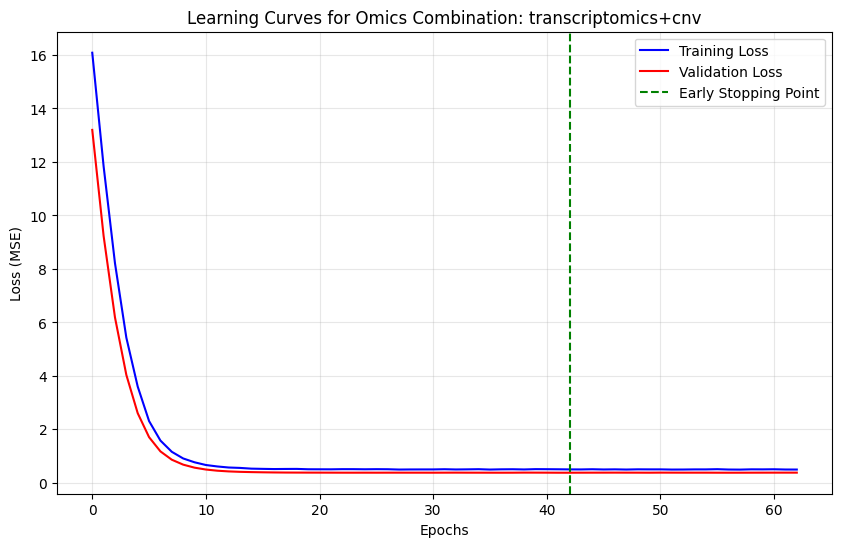

Adding cnv → R² = 0.8376 (Δ = -0.0003)


,Added Omics,Test Set,R²,RMSE,Improvement
2,cnv,transcriptomics+cnv,0.837623,0.695195,-0.000275
0,methylation,transcriptomics+methylation,0.837291,0.695905,-0.000607
1,metabolomics,transcriptomics+metabolomics,0.837180,0.696142,-0.000718



No further improvement. Best set: ['transcriptomics'], R²: 0.8379


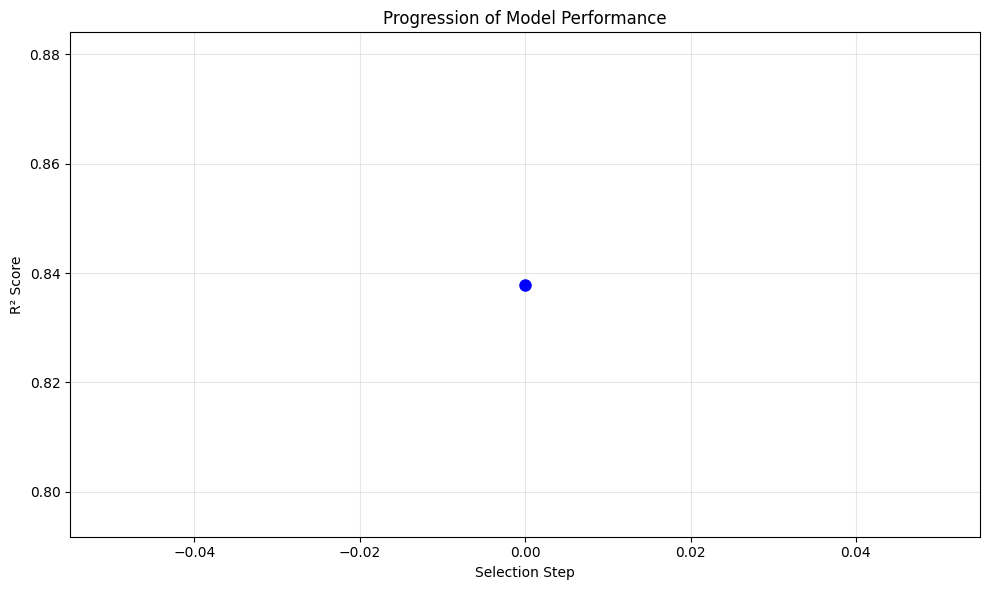



===== SUMMARY OF ALL COMBINATIONS =====
Omics Set                      R²         RMSE       MAE        EVS        Fusion          Activation
------------------------------------------------------------------------------------------
transcriptomics                0.8379     0.6946     0.5057     0.8382     gated           relu      
transcriptomics+cnv            0.8376     0.6952     0.5063     0.8377     hierarchical    relu      
transcriptomics+methylation    0.8373     0.6959     0.5058     0.8377     cross_attention relu      
transcriptomics+metabolomics   0.8372     0.6961     0.5060     0.8377     cross_attention relu      


<Figure size 1200x800 with 0 Axes>

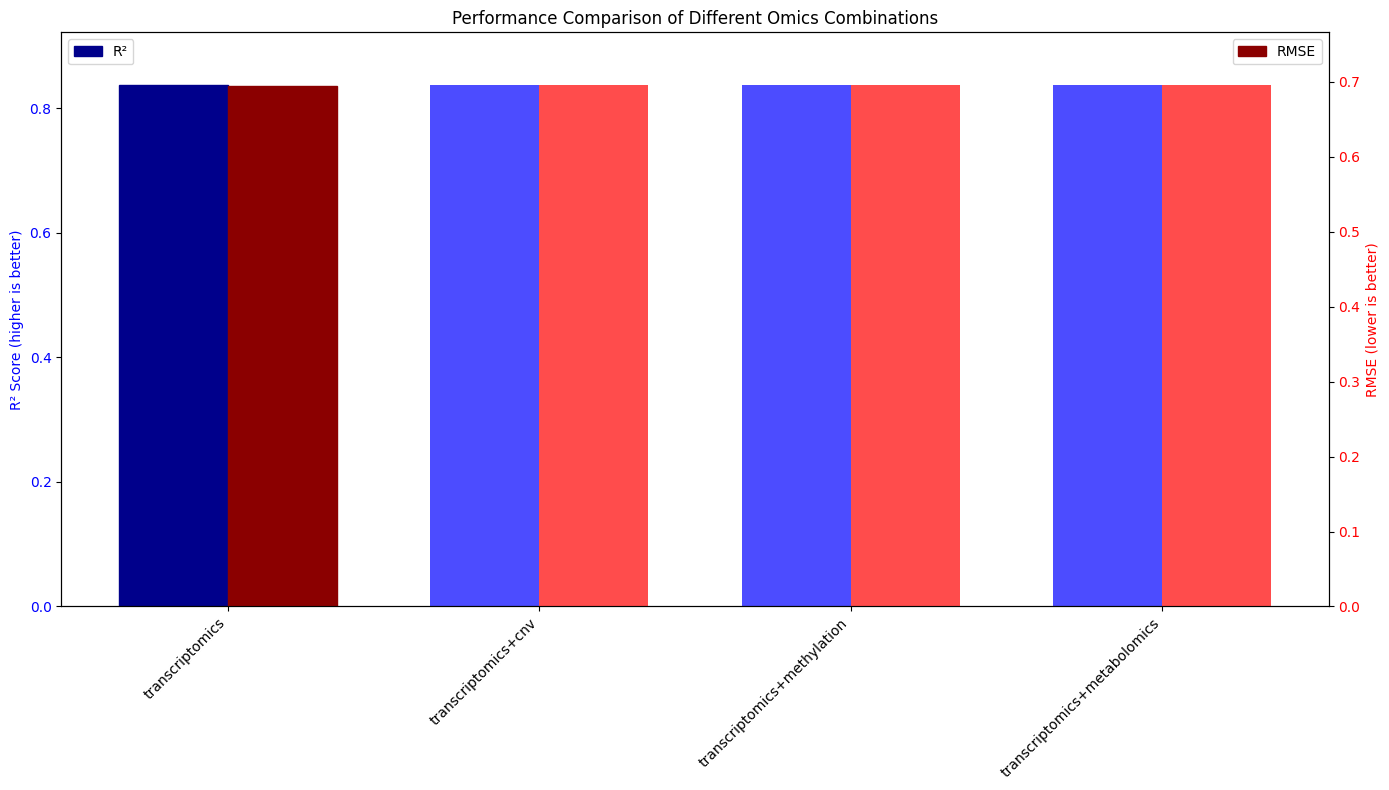

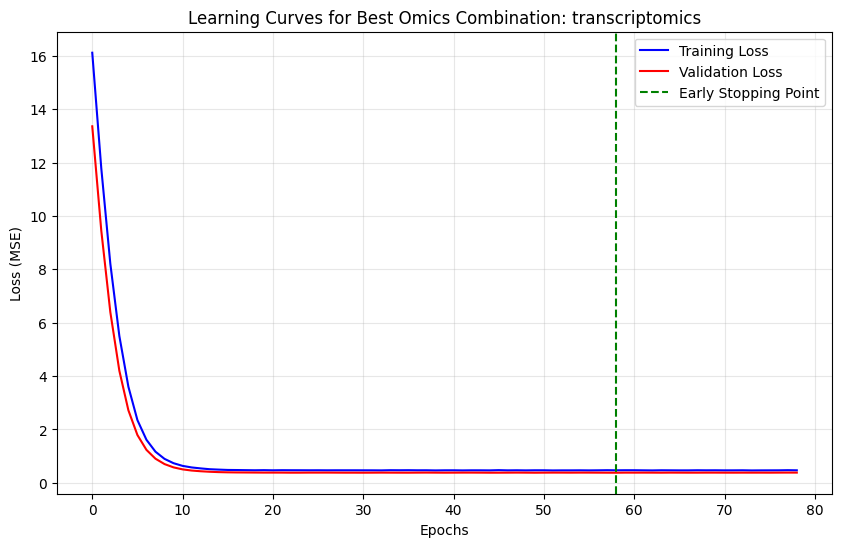

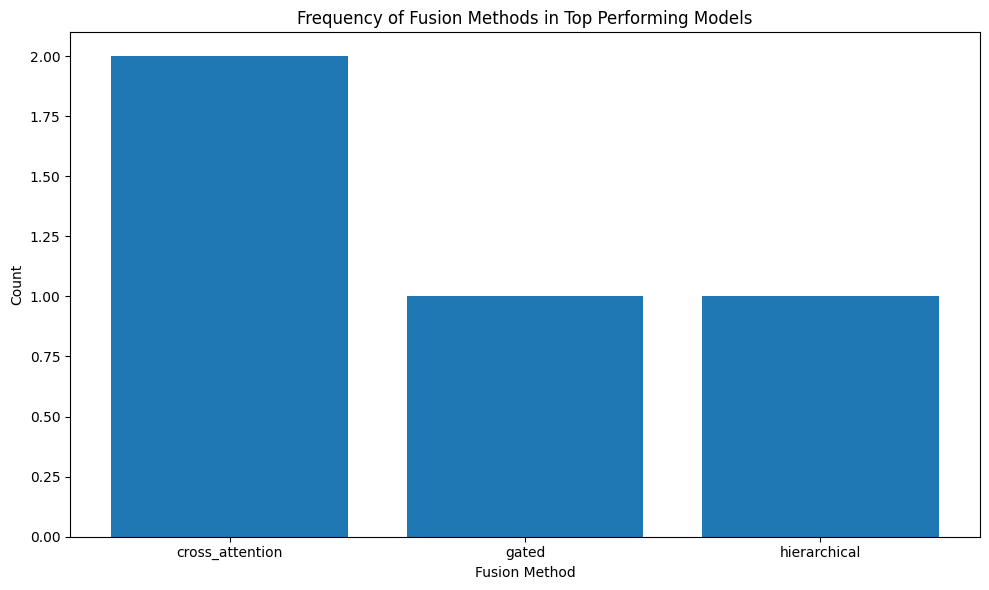


Best omics combination found: transcriptomics
Best R^2 score: 0.8379


(['transcriptomics'],
 {'num_heads': 4,
  'num_layers': 6,
  'hidden_dim': 384,
  'dropout_rate': 0.1,
  'learning_rate': 0.0009052341259832195,
  'weight_decay': 1.1016969061267455e-06,
  'fusion_method': 'gated',
  'activation_function': 'relu'})

In [26]:
# All omics list
all_omics_types = ["methylation", "metabolomics", "transcriptomics", "cnv"]

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Run the progressive selection process
all_results, best_omics_set, progress_df = progressive_omics_selection(all_omics_types, n_trials=20)

# Summarise the results
summary = summarise_results(all_results, best_omics_set)

# Save the progress dataframe
progress_df.to_csv(result_path / "progressive_selection_results.csv", index=False)

# Print the best combination
print(f"\nBest omics combination found: {'+'.join(best_omics_set)}")
print(f"Best R^2 score: {all_results[tuple(best_omics_set)]['R2']:.4f}")

# Save the best model's hyperparameters
best_params = all_results[tuple(best_omics_set)]["Hyperparameters"]
best_params_df = pd.DataFrame([best_params])
best_params_df.to_csv(result_path / "best_model_hyperparameters.csv", index=False)

best_omics_set, best_params

# Results Transformer Models <a id="results-transformer"></a>

- Best omics combination found: transcriptomics only
- Best R² score: 0.8379

(['transcriptomics'],
 {'num_heads': 4,
  'num_layers': 6,
  'hidden_dim': 384,
  'dropout_rate': 0.1,
  'learning_rate': 0.0009052341259832195,
  'weight_decay': 1.1016969061267455e-06,
  'fusion_method': 'gated',
  'activation_function': 'relu'})


## Observations
Although gated fusion method gave the best R^2 score, cross-attention was the most frequently occuring fusion method in top performing models. Perhaps for future work, after cross-validation, dealing with outliers, and especially when the data amount grows, the cross-attention method could be the better performing one.

# Feature Analysis <a id="feature-analysis"></a>

Look at best predicting proteomic features.


Analysing feature-level performance...

--------------------------------------------------------------------------------
Analysing feature-level performance for best model: ['transcriptomics']
--------------------------------------------------------------------------------


/tmp/ipykernel_2606223/1692960922.py:67: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2606223/1692960922.py:67: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2606223/1692960922.py:67: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2606223/1692960922.py:67: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2606223/1692960922.py:67: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_p


Top 10 best predicted features:


,Feature,R2,RMSE,MAE,Correlation,P_value
2587,NBAS,0.000237,0.333540,0.260252,0.582853,0.000239
2425,MRPL18,0.000203,0.437633,0.347377,0.614880,0.000085
2430,MRPL23,0.000201,0.482791,0.391983,0.650734,0.000023
2548,MYO1B,0.000142,0.609084,0.485759,0.525912,0.001176
2976,PDIA6,0.000129,0.480627,0.379363,0.603052,0.000126
4675,UQCRC1,0.000129,0.576798,0.476663,0.593700,0.000170
1428,FBXO22,0.000123,0.358574,0.295139,0.548903,0.000639
4795,WDR75,0.000122,0.345262,0.271033,0.494660,0.002522
2862,OS9,0.000116,0.606212,0.478487,0.688038,0.000005
3298,PRPSAP1,0.000094,0.523188,0.404732,0.361332,0.032951



Bottom 10 worst predicted features:


,Feature,R2,RMSE,MAE,Correlation,P_value
4089,SPATS2L,-0.232327,0.801084,0.665394,0.250899,0.146001
3360,PSPH,-0.241867,0.915077,0.665961,-0.440087,0.008155
2223,LYRM7,-0.267294,0.496454,0.398635,0.048093,0.783816
602,CCN1,-0.268506,0.653079,0.535651,0.336736,0.047929
494,C17orf75,-0.290804,0.284711,0.232540,0.194283,0.263419
1169,DUS2,-0.291980,0.346978,0.272138,-0.053347,0.760854
907,CRYZL1,-0.299547,0.397953,0.310647,-0.244511,0.156892
34,ABRACL,-0.331639,0.795652,0.616579,0.322597,0.058747
3587,RHOB,-0.337894,0.645801,0.538274,0.286626,0.095048
410,BAP18,-0.370346,0.640315,0.456278,-0.283017,0.099472


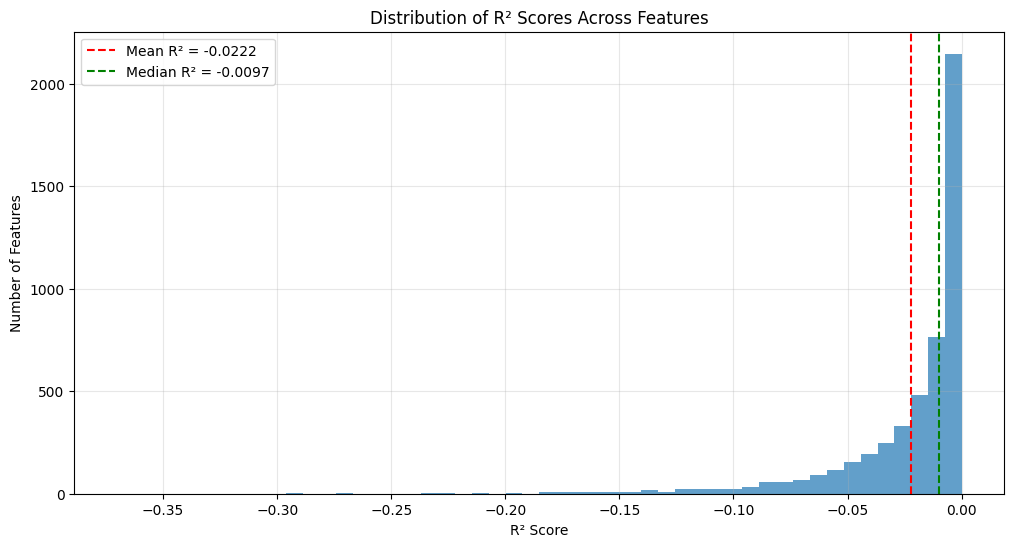

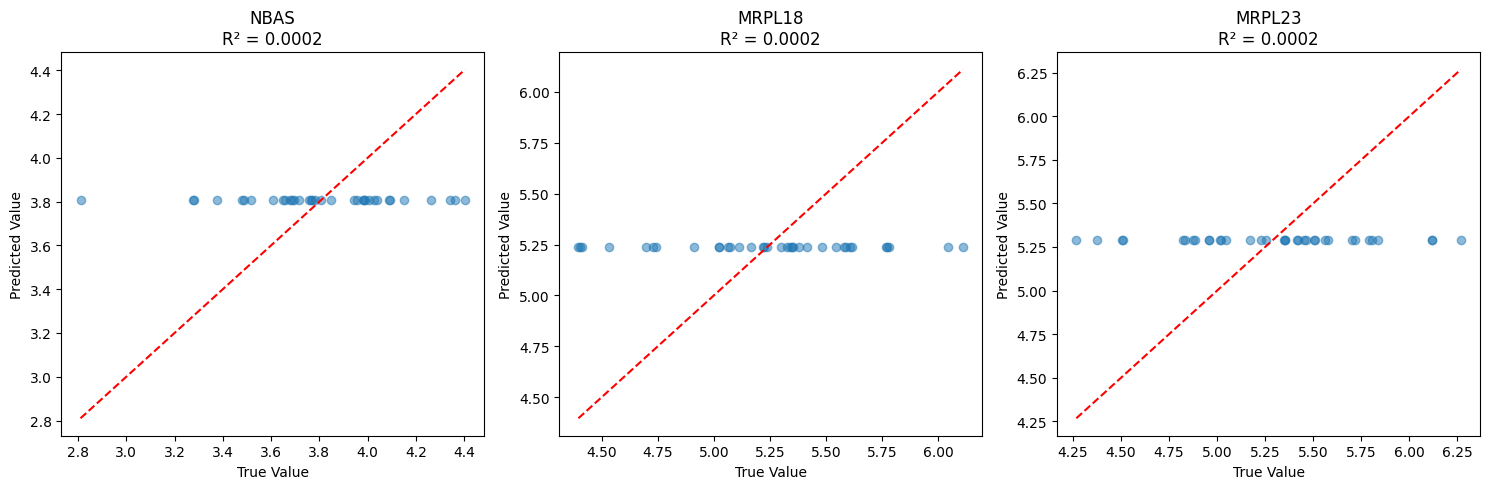

In [27]:
def analyse_feature_level_performance(best_omics_set, best_params):
    """
    Analyse which individual genes/features were predicted best by the model
    
    Parameters:
    -----------
    best_omics_set : list
        The best combination of omics types
    best_params : dict
        Best hyperparameters for the model
        
    Returns:
    --------
    feature_metrics : pd.DataFrame
        DataFrame with performance metrics for each feature
    """
    print(f"\n{'-'*80}")
    print(f"Analysing feature-level performance for best model: {best_omics_set}")
    print(f"{'-'*80}")
    
    # Prepare data loaders
    train_loader, val_loader, test_loader, input_dims, output_dim = prepare_data_loaders(
        best_omics_set, test_size=0.2, batch_size=64
    )
    
    # Get the feature names from the proteomics data
    target_feature_names = datasets["proteomics"].columns.tolist()[1:]  # Skip the ID column
    
    # Separate out parameters from model vs. training process 
    model_params = {k: v for k, v in best_params.items() if k not in ['learning_rate', 'weight_decay', 'batch_size', 'epochs']}
    model = ModularMultiOmicsTransformer(
        input_dims=input_dims,
        output_dim=output_dim,
        **model_params
    ).to(device)
    
    # Load the best model weights
    model_name = f"best_model_{'_'.join(best_omics_set)}.pth"
    model.load_state_dict(torch.load(model_path / model_name))
    model.eval()
    
    # Collect predictions and targets
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs_dict, targets in test_loader:
            inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
            targets = targets.to(device)
            
            outputs = model(inputs_dict)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate metrics for each feature
    feature_metrics = []
    for i in range(output_dim):
        y_true = all_targets[:, i]
        y_pred = all_predictions[:, i]
        
        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        corr, p_value = pearsonr(y_true, y_pred)
        
        # Store in dictionary
        feature_metrics.append({
            "Feature": target_feature_names[i] if i < len(target_feature_names) else f"Feature_{i}",
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
            "Correlation": corr,
            "P_value": p_value
        })
    
    # Sort by R2 (descending)
    feature_metrics = pd.DataFrame(feature_metrics)
    feature_metrics = feature_metrics.sort_values("R2", ascending=False)
    feature_metrics.to_csv("feature_level_performance.csv", index=False)
    
    # Display top and bottom performing features
    print("\nTop 10 best predicted features:")
    display(feature_metrics.head(10))
    
    print("\nBottom 10 worst predicted features:")
    display(feature_metrics.tail(10))
    
    # Plot distribution of R2 scores
    plt.figure(figsize=(12, 6))
    plt.hist(feature_metrics["R2"], bins=50, alpha=0.7)
    plt.axvline(feature_metrics["R2"].mean(), color="red", linestyle="--", 
                label=f"Mean R² = {feature_metrics['R2'].mean():.4f}")
    plt.axvline(feature_metrics["R2"].median(), color="green", linestyle="--", 
                label=f"Median R² = {feature_metrics['R2'].median():.4f}")
    plt.title("Distribution of R² Scores Across Features")
    plt.xlabel("R² Score")
    plt.ylabel("Number of Features")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot a few example scatter plots for best and worst features
    num_plots = min(3, len(feature_metrics))
    plt.figure(figsize=(15, 5))
    
    # Best features
    for i in range(num_plots):
        plt.subplot(1, num_plots, i+1)
        feature = feature_metrics.iloc[i]["Feature"]
        idx = target_feature_names.index(feature) if feature in target_feature_names else i
        
        plt.scatter(all_targets[:, idx], all_predictions[:, idx], alpha=0.5)
        plt.plot([min(all_targets[:, idx]), max(all_targets[:, idx])], 
                 [min(all_targets[:, idx]), max(all_targets[:, idx])], "r--")
        plt.title(f"{feature}\nR² = {feature_metrics.iloc[i]['R2']:.4f}")
        plt.xlabel("True Value")
        plt.ylabel("Predicted Value")
    
    plt.tight_layout()
    plt.show()
    
    return feature_metrics


print("\nAnalysing feature-level performance...")
feature_performance = analyse_feature_level_performance(best_omics_set, best_params)

# Best Predicting Protein Features <a id="results-feature-analysis"></a>

The results that the best predicting proteomic features actually have very low R^2 values, which indicates weak prediction performance and not a lot of variability is explained. The correlation values between the predicted and actual values >0.5 with significant p-values, so the model seems to capture some meaningful relationship between input omics data and protein expression, but not strongly. 


The disconnect between the correlation values and the very low R^2 values suggests that while the model is capturing some general trends in protein expression (hence the correlations), it's not accurately predicting the exact values (hence the poor R^2 values). This could be due to scaling issues in the predictions or systematic biases that the model hasn't learned to correct.


The RMSE values are consistently higher than MAE, suggesting some (larger) errors in the predictions. This because RMSE is more sensitive to outliers (quadratic penalty).